In [ ]:
!pip install awswrangler mlflow

The main tables available for this project is orders and order_items.
The order table indicate a purchase.
  - Which customer made the purchase?
  - Status of the purchase (invoiced, delivered, approved...)
  - Purchase timestamp.
  - Delivery Carrier timestamp.
  - Delivery to customer timestamp.
  - Estimated Delivery timestamp.

The order_items indicates all items in the same order (multiple products per basket).
  - In the same order, how many products has been purchased ?
  - Products has been purchased.
  - Seller that selled the product.
  - Shipping limit date.
  - Product price.
  - Freight Value.


The Abt Features:

- recency: Feature created for create target, is the day from last selling.
- avg_ticket: Avg Ticket, is the price over products.
- avg_order_product: The quantity of products over unique orders.
- max_order_items_price: Each order can have multiple products and multiple items for same product, what are the max price of the items of products in orders.
- min_order_items_price: Each order can have multiple products and multiple items for same product, what are the min price of the items of products in orders.
- avg_order_items_price: Each order can have multiple products and multiple items for same product, what are the avg price of the items of products in orders.
- max_item_price: Each order can have multiple items, what are the max price of the order items.
- min_item_price: Each order can have multiple items, what are the min price of the order items.
- avg_item_price: Each order can have multiple items, what are the avg price of the order items.
- quantity_date_orders: Quantity of unique orders by each date the seller have at least one order. 
- quantity_products_selled: Total selled products by seller.
- quantity_unique_product_selled: Total unique prodicts selled by seller.
- avg_seller_interval: Average days interval between seller selling.
- ltv: Cumulative sum of price history of seller.
- days_from_first_sell: Days util seller is in the olist.
- frequency: Quantity unique orders over difference between first and last purchases.
- avg_freight_value: Avg freight value over all items. 
- min_freight_value: Min freight value over all items. 
- max_freight_value: Max freight value over all items. 
- avg_approval_delivery_days: Avg delay to delivery in days.
- min_approval_delivery_days: Min delay to delivery in days.
- max_approval_delivery_days: Max delay to delivery in days.
- avg_approval_purchase_days: Avg delay to approval in days.
- min_approval_purchase_days: Min delay to approval in days.
- max_approval_purchase_days: Max delay to approval in days.
- churn: Flag created with Recency.

# 0.0. Requirements

## 0.1. Imports

In [1]:
import numpy as np
import pandas as pd
import awswrangler as wr

from scipy import stats
from IPython.display import Image

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from warnings import filterwarnings

filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

## 0.2. Aux Functions

In [90]:
def read_query(
    query_name: str
) -> pd.DataFrame:
    query = ' '.join(open(f"./silver_descriptive_sql_query/{query_name}.sql", "r").readlines())
    return wr.athena.read_sql_query(sql=query, database="grc_iceberg_silver")

def plot_h_selling_interval(
    df: pd.DataFrame,
    mask: pd.Series,
    selling_interval_col: str = "avg_seller_interval",
):
    df["selling_interval"] = df[selling_interval_col].astype(int)
    df["interval_one_week"] = df["selling_interval"].apply(lambda x: 1 if x > 7 else 0)

    churn_interval = df[mask]["interval_one_week"].value_counts() / len(df)
    no_churn_interval = df[~mask]["interval_one_week"].value_counts() / len(df)

    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    ax = ax.flatten()

    ax[0].hist(df["selling_interval"], bins=10, histtype="step", linewidth=2);
    ax[1].hist(df[mask]["selling_interval"], bins=10, color="r", histtype="step", linewidth=2, label="churn")
    ax[1].hist(df[~mask]["selling_interval"], bins=10, color="b", histtype="step", linewidth=2, label="no churn")
    ax[2].hist(np.log1p(df[mask]["selling_interval"]), bins=10, density=True, color="r", histtype="step", linewidth=2, label="churn")
    ax[2].hist(np.log1p(df[~mask]["selling_interval"]), bins=10, density=True, color="b", histtype="step", linewidth=2, label="no churn")

    ax[3].bar(churn_interval.index, churn_interval.values, color="r", width=0.25, label="churn")
    ax[3].bar(no_churn_interval.index + 0.25, no_churn_interval.values, color="b", width=0.25, label="no churn")
    ax[3].set_xticks([0.15, 1.15], [0, 1])

    ax[0].set_title("Hist Interval")
    ax[1].set_title("Hist Churn / No Churn Interval")
    ax[2].set_title("Hist LogNorm Churn / No Churn")
    ax[3].set_title("R. Frequency One Week")

    for axi in ax:
        axi.legend()
        axi.grid();

    print(df.avg_seller_interval.describe())

def plot_h_one_year_selling(
    df: pd.DataFrame,
    mask: pd.Series,
    days_from_first_sell_col: str = "days_from_first_sell",
):
    df["one_year"] = df[days_from_first_sell_col].apply(lambda x: 1 if x > 365 else 0)

    churn_interval = df[mask]["one_year"].value_counts() / len(df)
    no_churn_interval = df[~mask]["one_year"].value_counts() / len(df)

    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    ax = ax.flatten()

    ax[0].hist(df[days_from_first_sell_col], bins=10, histtype="step", linewidth=2);
    ax[1].hist(df[mask][days_from_first_sell_col], bins=10, color="r", histtype="step", linewidth=2, label="churn")
    ax[1].hist(df[~mask][days_from_first_sell_col], bins=10, color="b", histtype="step", linewidth=2, label="no churn")
    ax[2].hist(np.log1p(df[mask][days_from_first_sell_col]), bins=10, density=True, color="r", histtype="step", linewidth=2, label="churn")
    ax[2].hist(np.log1p(df[~mask][days_from_first_sell_col]), bins=10, density=True, color="b", histtype="step", linewidth=2, label="no churn")

    ax[3].bar(churn_interval.index, churn_interval.values, color="r", width=0.25, label="churn")
    ax[3].bar(no_churn_interval.index + 0.25, no_churn_interval.values, color="b", width=0.25, label="no churn")
    ax[3].set_xticks([0.15, 1.15], [0, 1])

    ax[0].set_title("Hist Days")
    ax[1].set_title("Hist Churn / No Churn Days")
    ax[2].set_title("Hist LogNorm Churn / No Churn")
    ax[3].set_title("R. Frequency One Year")

    for axi in ax:
        axi.legend()
        axi.grid();

    print(df[days_from_first_sell_col].describe())

def plot_h_histogram(
    df: pd.DataFrame,
    mask: pd.Series,
    histogram_col: str = "pct_delay_delivered_orders",
    lognorm: bool = True,
):
    df["one_year"] = df[histogram_col].apply(lambda x: 1 if x > 365 else 0)

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax = ax.flatten()

    ax[0].hist(df[histogram_col], bins=10, histtype="step", linewidth=2);
    ax[1].hist(df[mask][histogram_col], bins=10, color="r", histtype="step", linewidth=2, label="churn")
    ax[1].hist(df[~mask][histogram_col], bins=10, color="b", histtype="step", linewidth=2, label="no churn")
    
    if lognorm:
        ax[2].set_title("Hist LogNorm Churn / No Churn")
        ax[2].hist(np.log1p(df[mask][histogram_col]), bins=10, density=True, color="r", histtype="step", linewidth=2, label="churn")
        ax[2].hist(np.log1p(df[~mask][histogram_col]), bins=10, density=True, color="b", histtype="step", linewidth=2, label="no churn")

    else:
        ax[2].set_title("Hist Norm Churn / No Churn")
        ax[2].hist(df[mask][histogram_col], bins=10, density=True, color="r", histtype="step", linewidth=2, label="churn")
        ax[2].hist(df[~mask][histogram_col], bins=10, density=True, color="b", histtype="step", linewidth=2, label="no churn")

    ax[0].set_title("Hist")
    ax[1].set_title("Hist Churn / No Churn")

    for axi in ax:
        axi.legend()
        axi.grid();

    print(df[histogram_col].describe())

def plot_h_scatter_delay(
    df: pd.DataFrame,
    mask: pd.Series
):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    df[mask][["avg_approval_delivery_days", "pct_delay_delivered_orders"]].plot(
        kind="scatter",
        x="avg_approval_delivery_days", y="pct_delay_delivered_orders", ax=ax[0],
        color="r", label="churn", marker="*"
    )

    df[~mask][["avg_approval_delivery_days", "pct_delay_delivered_orders"]].plot(
        kind="scatter",
        x="avg_approval_delivery_days", y="pct_delay_delivered_orders", ax=ax[0],
        color="b", label="no churn", marker="x", grid=2
    )

    df[mask][["avg_approval_delivery_days", "avg_approval_purchase_days"]].plot(
        kind="scatter",
        x="avg_approval_delivery_days", y="avg_approval_purchase_days", ax=ax[1],
        color="r", label="churn", marker="*"
    )

    df[~mask][["avg_approval_delivery_days", "avg_approval_purchase_days"]].plot(
        kind="scatter",
        x="avg_approval_delivery_days", y="avg_approval_purchase_days", ax=ax[1],
        color="b", label="no churn", marker="x", grid=2
    )

    plt.legend()

def plot_h_scatter_delay_approval(
    df: pd.DataFrame,
    mask: pd.Series
):
    fig, ax = plt.subplots(3, 2, figsize=(7, 7))
    ax = ax.flatten()

    df[mask][["quantity_delay_orders", "min_approval_purchase_days"]].plot(
        kind="scatter",
        x="min_approval_purchase_days", y="quantity_delay_orders", ax=ax[0],
        color="r", label="churn", marker="*"
    )

    df[~mask][["quantity_delay_orders", "min_approval_purchase_days"]].plot(
        kind="scatter",
        x="min_approval_purchase_days", y="quantity_delay_orders", ax=ax[0],
        color="b", label="no churn", marker="x", grid=2
    )

    df[mask][["quantity_delay_orders", "max_approval_purchase_days"]].plot(
        kind="scatter",
        x="max_approval_purchase_days", y="quantity_delay_orders", ax=ax[2],
        color="r", label="churn", marker="*"
    )

    df[~mask][["quantity_delay_orders", "max_approval_purchase_days"]].plot(
        kind="scatter",
        x="max_approval_purchase_days", y="quantity_delay_orders", ax=ax[2],
        color="b", label="no churn", marker="x", grid=2
    )

    df[mask][["min_approval_purchase_days", "max_approval_purchase_days"]].plot(
        kind="scatter",
        x="max_approval_purchase_days", y="min_approval_purchase_days", ax=ax[4],
        color="r", label="churn", marker="*"
    )

    df[~mask][["min_approval_purchase_days", "max_approval_purchase_days"]].plot(
        kind="scatter",
        x="max_approval_purchase_days", y="min_approval_purchase_days", ax=ax[4],
        color="b", label="no churn", marker="x", grid=2
    )

    np.log1p(df[mask]["min_approval_purchase_days"]).hist(label="churn", density=True, color="r", bins=10, histtype="step", ax=ax[1])
    np.log1p(df[~mask]["min_approval_purchase_days"]).hist(label="no churn", density=True, color="b", bins=10, histtype="step", ax=ax[1])

    np.log1p(df[mask]["max_approval_purchase_days"]).hist(label="churn", density=True, color="r", bins=10, histtype="step", ax=ax[3])
    np.log1p(df[~mask]["max_approval_purchase_days"]).hist(label="no churn", density=True, color="b", bins=10, histtype="step", ax=ax[3])

    np.log1p(df[mask]["avg_approval_purchase_days"]).hist(label="churn", density=True, color="r", bins=10, histtype="step", ax=ax[5])
    np.log1p(df[~mask]["avg_approval_purchase_days"]).hist(label="no churn", density=True, color="b", bins=10, histtype="step", ax=ax[5])

    ax[1].legend()

    plt.tight_layout()

def plot_h_scatter_selling_interval(
    df: pd.DataFrame,
    mask: pd.Series
):

    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    ax = ax.flatten()

    df[mask][["frequency", "avg_seller_interval"]].plot(
        kind="scatter",
        x="avg_seller_interval", y="frequency", ax=ax[0],
        color="r", label="churn", marker="*"
    )

    df[~mask][["frequency", "avg_seller_interval"]].plot(
        kind="scatter",
        x="avg_seller_interval", y="frequency", ax=ax[0],
        color="b", label="no churn", marker="x", grid=2
    )

    df[mask][["days_from_first_sell", "avg_seller_interval"]].plot(
        kind="scatter",
        x="avg_seller_interval", y="days_from_first_sell", ax=ax[2],
        color="r", label="churn", marker="*"
    )

    df[~mask][["days_from_first_sell", "avg_seller_interval"]].plot(
        kind="scatter",
        x="avg_seller_interval", y="days_from_first_sell", ax=ax[2],
        color="b", label="no churn", marker="x", grid=2
    )

    np.log1p(df[mask]["frequency"]).hist(label="churn", density=True, color="r", bins=10, histtype="step", ax=ax[1])
    np.log1p(df[~mask]["frequency"]).hist(label="no churn", density=True, color="b", bins=10, histtype="step",  ax=ax[1])
    np.log1p(df[mask]["days_from_first_sell"]).hist(label="churn", density=True, color="r", bins=10, histtype="step", ax=ax[-1])
    np.log1p(df[~mask]["days_from_first_sell"]).hist(label="no churn", density=True, color="b", bins=10, histtype="step",  ax=ax[-1])

    ax[1].legend()

    plt.tight_layout()

## 0.3. Read Data

In [ ]:
df = wr.athena.read_sql_query(
    sql="SELECT * FROM abt_seller_churn",
    database="grc_iceberg_analytics"
)

Some of the records from 2018-09-01 and 2018-10-01 do not exists on real dataset (orders and order_items).

I will consider the last month (2018-09-01) for new sellers scoring, such as production.

And i will use 2018-01-01 and 2018-07-01 as a train and test and 2018-08-01 as a oot base.

In [4]:
df[["seller_id", "_mt_date_reference", "churn"]].groupby(["_mt_date_reference", "churn"]).count().reset_index()

,_mt_date_reference,churn,seller_id
0,2018-01-01,0,674
1,2018-01-01,1,370
2,2018-02-01,0,723
3,2018-02-01,1,305
4,2018-03-01,0,757
5,2018-03-01,1,339
6,2018-04-01,0,788
7,2018-04-01,1,310
8,2018-05-01,0,833
9,2018-05-01,1,399


In [5]:
df = df[df["_mt_date_reference"] <= "2018-08-01"].reset_index(drop=True)
df_raw = df[df["_mt_date_reference"] < "2018-08-01"].reset_index(drop=True)
df_oot = df[df["_mt_date_reference"] >= "2018-08-01"].reset_index(drop=True)

In [6]:
id_cols = ["_mt_date_reference", "seller_id"]
target_col = ["churn"]

df_raw.drop(columns=id_cols, inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df_raw[df_raw.columns.drop(target_col)],
    df_raw[target_col],
    random_state=2,
    train_size=0.8
)

In [8]:
print(y_train.mean())
print(y_test.mean())
print(df_oot[target_col].mean())

churn    0.322576
dtype: float64
churn    0.311414
dtype: float64
churn    0.334993
dtype: float64


In [9]:
df_oot[target_col[0]].value_counts()

churn
0    935
1    471
Name: count, dtype: int64

# 1.0. Descriptive Statistics

In [25]:
df1 = X_train.copy()
df1["churn"] = y_train
mask = df1["churn"] == 1

## 1.1. Data Dimension

In [26]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Cols: {df1.shape[1]}")

Number of Rows: 6445
Number of Cols: 27


## 1.2. Check Missing Values

In [27]:
df1.isna().sum() / len(df1)

avg_ticket                        0.000000
avg_order_product                 0.000000
max_order_items_price             0.000000
min_order_items_price             0.000000
avg_order_items_price             0.000000
max_item_price                    0.000000
min_item_price                    0.000000
avg_item_price                    0.000000
quantity_date_orders              0.000000
quantity_products_selled          0.000000
quantity_unique_product_selled    0.000000
avg_seller_interval               0.108456
ltv                               0.000000
days_from_first_sell              0.000000
frequency                         0.092785
avg_freight_value                 0.000000
min_freight_value                 0.000000
max_freight_value                 0.000000
avg_approval_delivery_days        0.000000
min_approval_delivery_days        0.000000
max_approval_delivery_days        0.000000
avg_approval_purchase_days        0.000000
min_approval_purchase_days        0.000000
max_approva

## 1.3. Fillout Missing Values

In [28]:
fill_zero = [
    "avg_seller_interval",
    "frequency"
]

for k in fill_zero:
    df1[k].fillna(0, inplace=True)

## 1.4. Descriptive Statistics

### 1.4.1. ABT Descriptive Checkout

In [16]:
dfm = pd.DataFrame([
    df1.apply(lambda x: x.skew()),
    df1.apply(lambda x: ((x.quantile(.75) - x.quantile(.5)) - (x.quantile(.5) - x.quantile(.25))) / 1 + (x.quantile(.75) - x.quantile(.25))),
    df1.apply(lambda x: x.kurtosis())
]).T

dfm.columns = ["skew", "bowley", "kurtosis"]

In [17]:
pd.concat([df1.describe().T, dfm], axis=1).iloc[:, 1:]

,mean,std,min,25%,50%,75%,max,skew,bowley,kurtosis
recency,13.664391,12.035156,1.000000,4.000000,10.000000,21.000000,45.000000,0.921996,22.000000,-0.184728
avg_ticket,159.804628,219.257032,3.746667,57.203000,98.438235,170.610000,2899.000000,5.097635,144.343529,37.462604
avg_order_product,1.070132,0.366654,1.000000,1.000000,1.000000,1.000000,8.000000,7.777155,0.000000,81.977277
max_order_items_price,421.337547,519.891834,3.850000,137.700000,259.900000,499.250000,13440.000000,5.201906,478.700000,73.494734
min_order_items_price,85.508045,169.068119,0.850000,19.990000,39.900000,89.000000,2899.000000,7.464078,98.200000,79.139293
avg_order_items_price,176.332577,238.248985,3.746667,66.401935,111.926667,189.250000,6543.000000,6.985603,154.646667,105.170500
max_item_price,334.565212,429.239111,3.850000,100.500000,190.000000,379.900000,4590.000000,3.598569,379.800000,18.364721
min_item_price,84.279327,169.165222,0.850000,19.900000,39.900000,84.900000,2899.000000,7.470572,90.000000,79.166599
avg_item_price,159.804628,219.257032,3.746667,57.203000,98.438235,170.610000,2899.000000,5.097635,144.343529,37.462604
quantity_date_orders,19.411482,26.539240,1.000000,3.000000,9.000000,24.000000,182.000000,2.825058,30.000000,9.875549


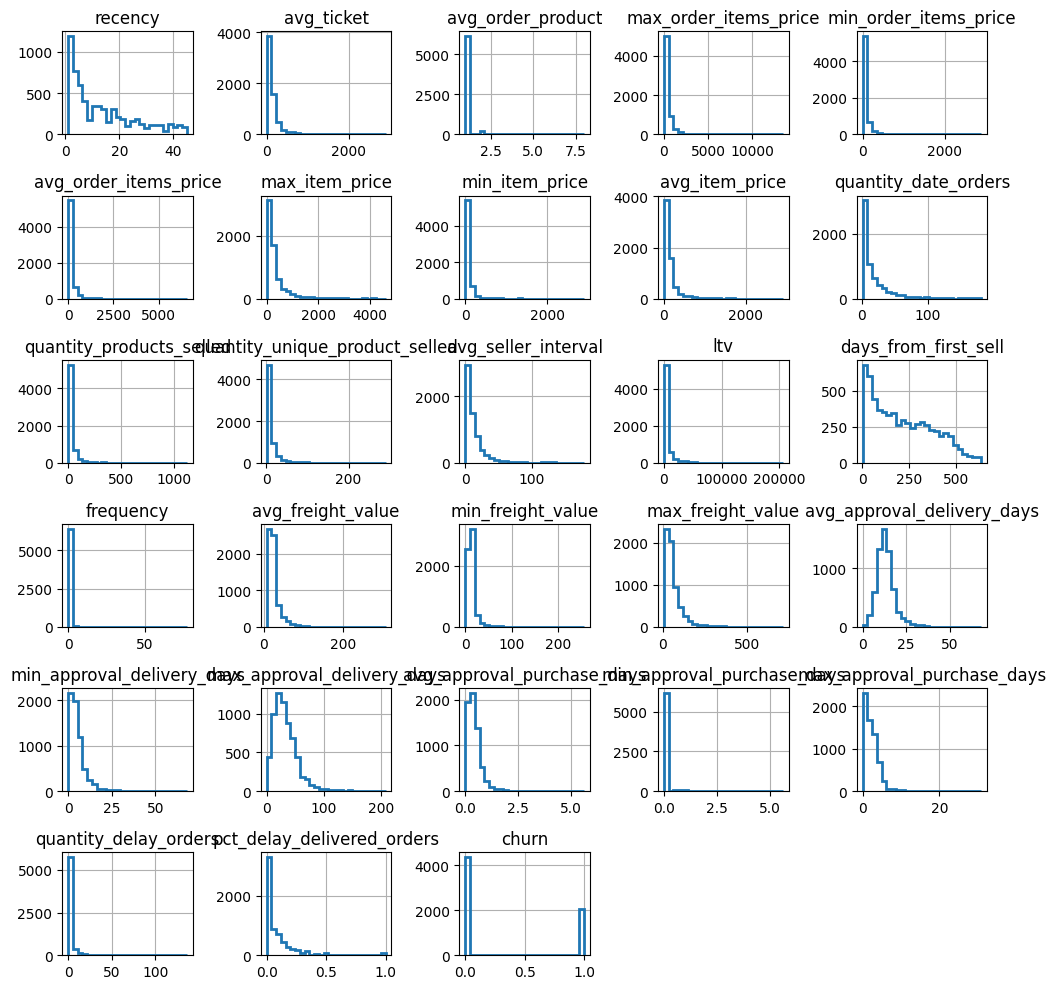

In [18]:
df1.hist(bins=25, figsize=(10, 10), histtype="step", linewidth=2);
plt.tight_layout()

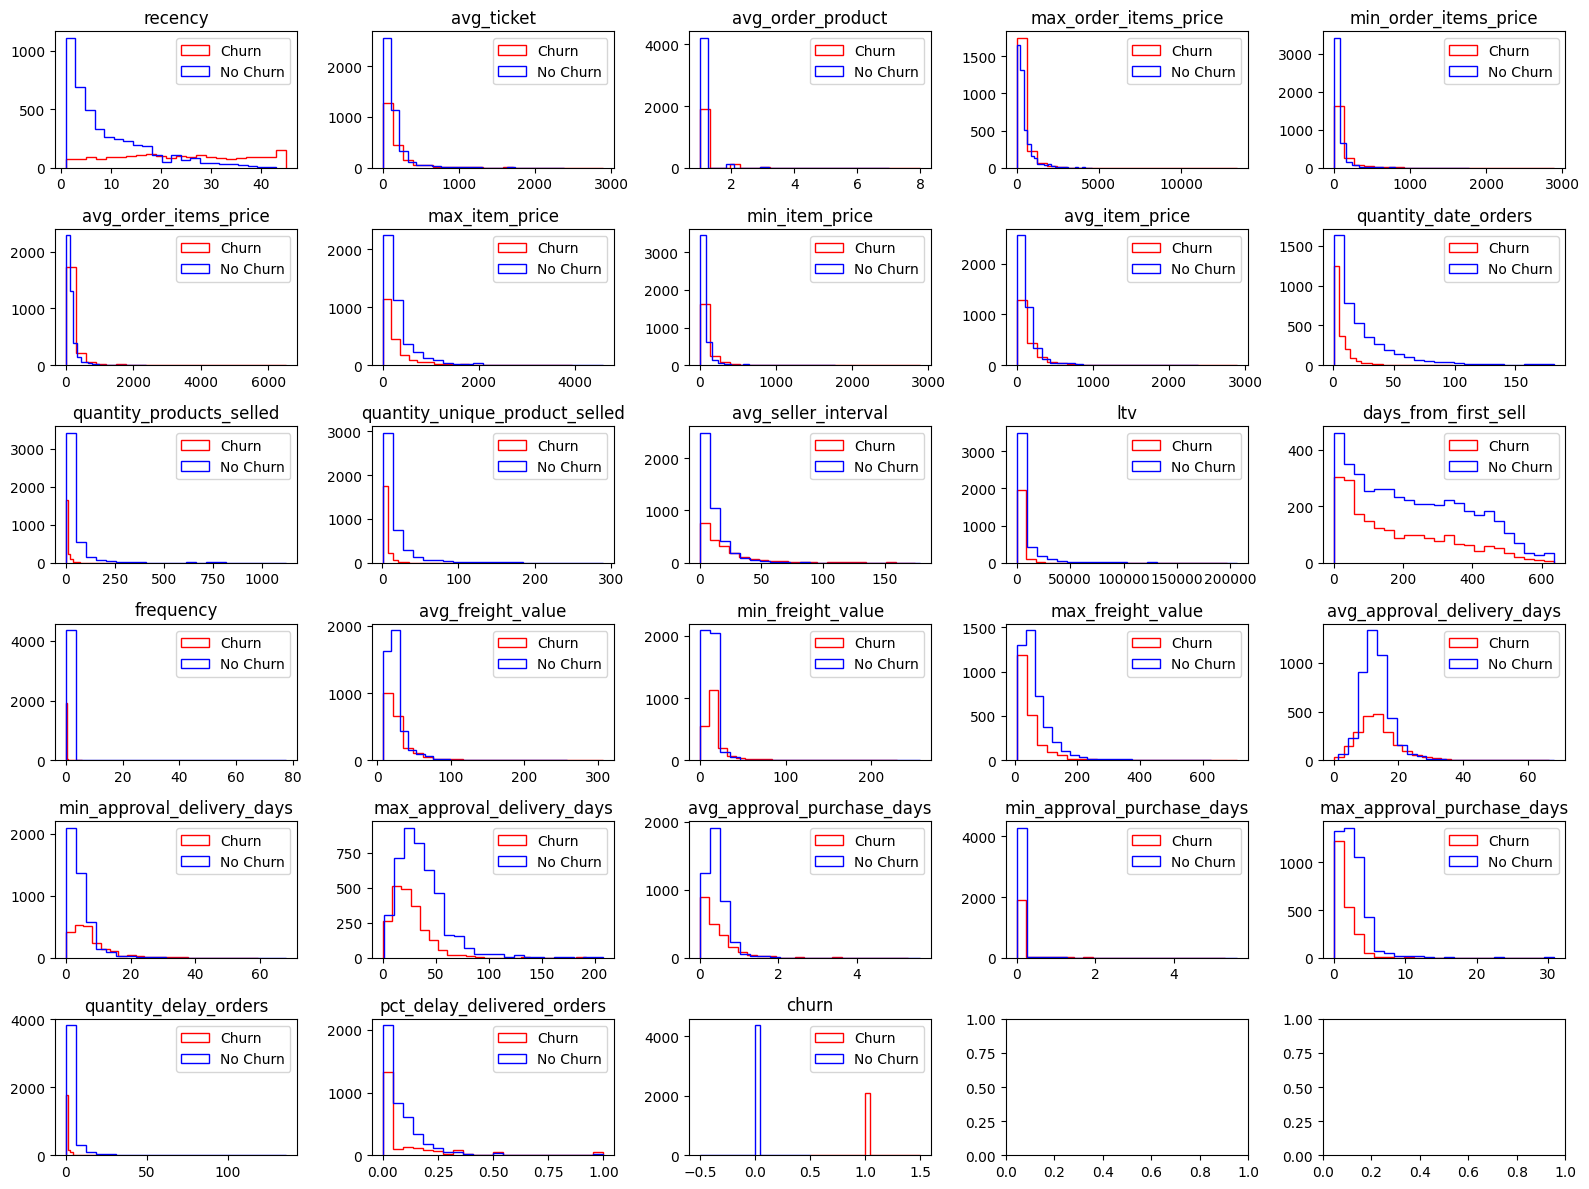

In [19]:
fig, ax = plt.subplots(6, 5, figsize=(16, 12))
ax = ax.flatten()

for axi, col in zip(ax, df1.columns):
    axi.hist(df1[mask][col], bins=22, color="r", histtype="step", label="Churn")
    axi.hist(df1[~mask][col], bins=22, color="b", histtype="step", label="No Churn")
    axi.set_title(col)
    axi.legend()

plt.tight_layout()

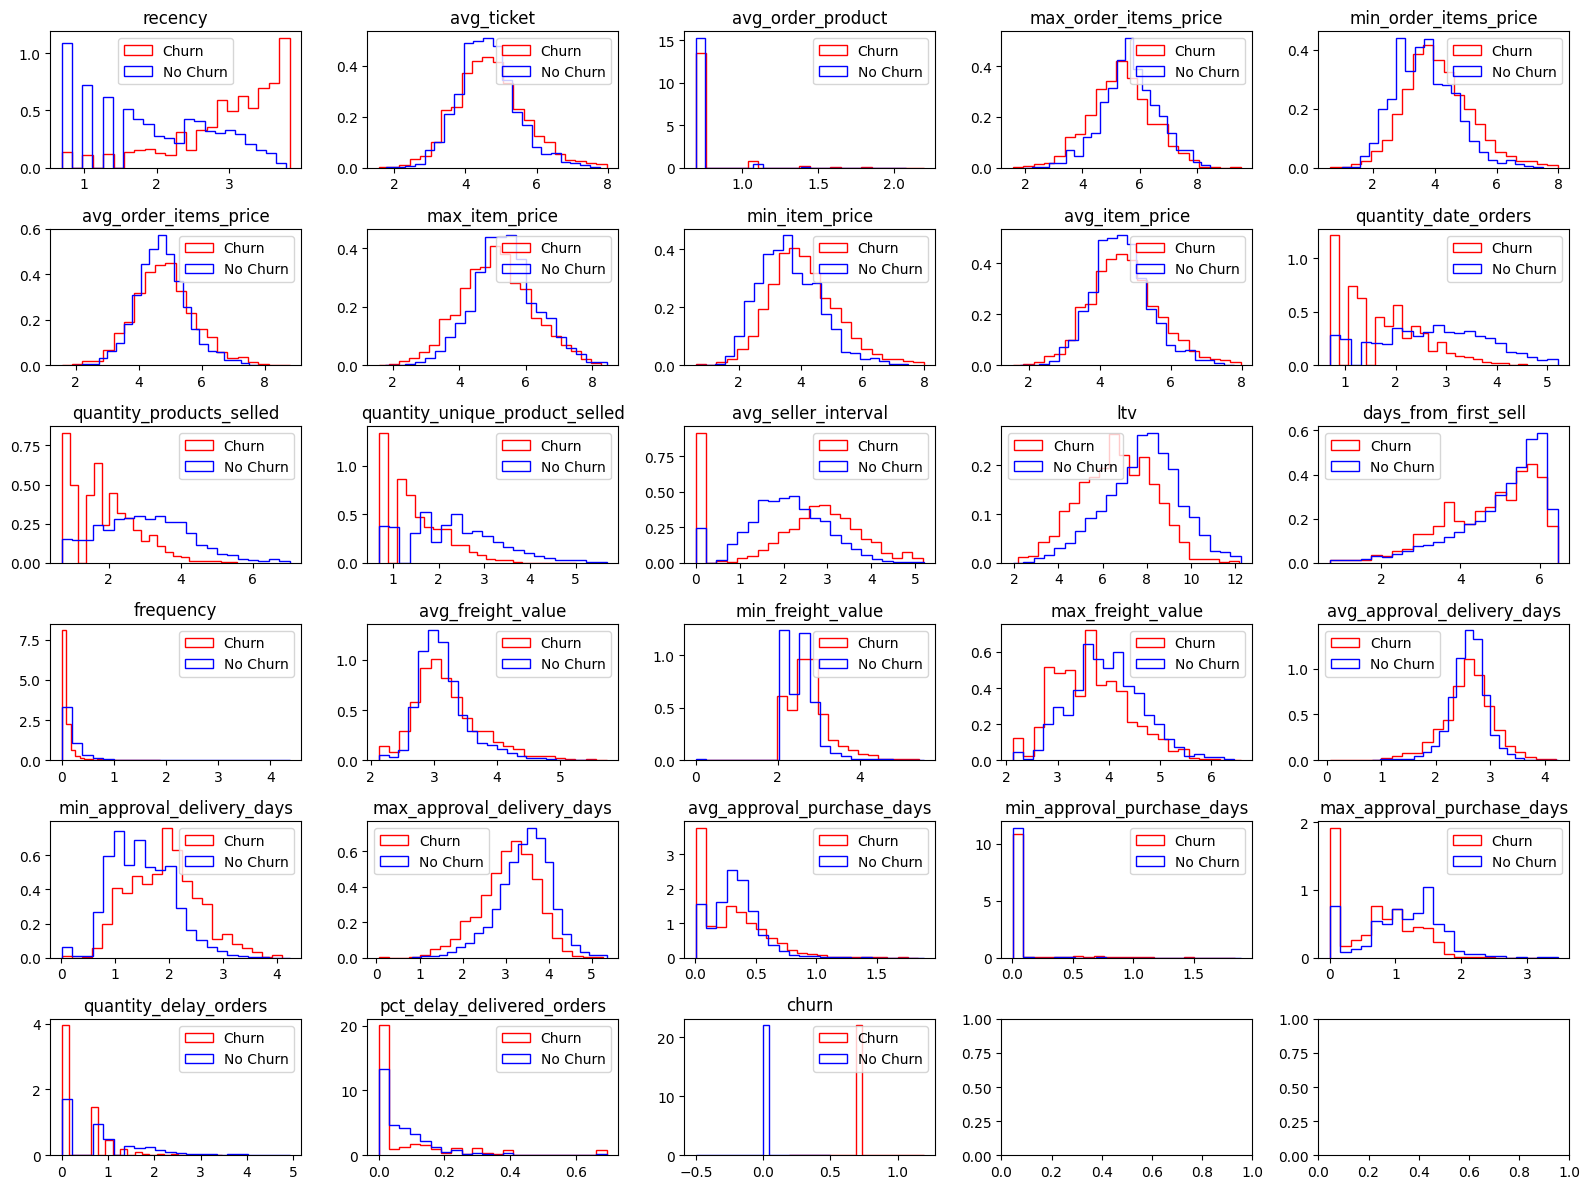

In [21]:
fig, ax = plt.subplots(6, 5, figsize=(16, 12))
ax = ax.flatten()

for axi, col in zip(ax, df1.columns):
    axi.hist(np.log1p(df1[mask][col]), density=True, bins=22, color="r", histtype="step", label="Churn")
    axi.hist(np.log1p(df1[~mask][col]), density=True, bins=22, color="b", histtype="step", label="No Churn")
    axi.set_title(col)
    axi.legend()

plt.tight_layout()

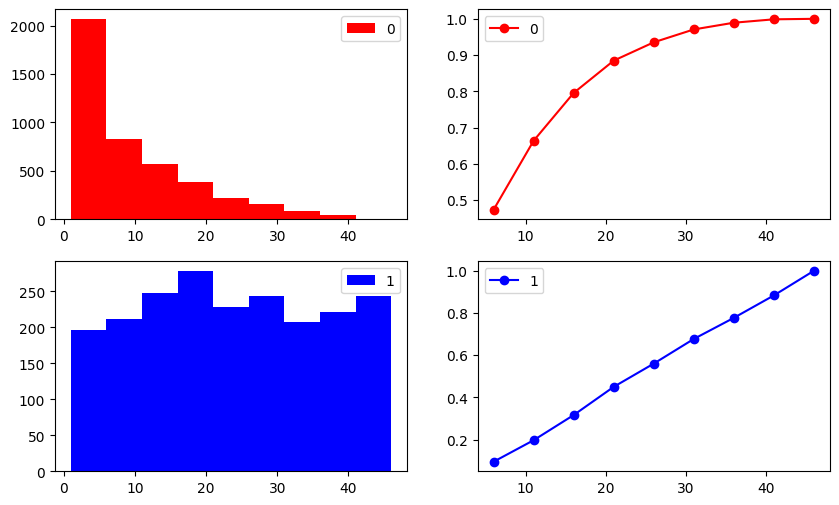

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()

for c, axi, color in zip(df1["churn"].unique(), [[0, 1], [2, 3]], ["r", "b"]):
    msk_sort = df1.loc[df1["churn"] == c, ["recency"]]
    n, bins, _ = ax[axi[0]].hist(msk_sort, bins=np.arange(1, 50, 5), color=color, label=c)
    ax[axi[1]].plot(bins[1:], np.cumsum(n / len(msk_sort)), marker="o", color=color, label=c)

    ax[axi[0]].legend();
    ax[axi[1]].legend();

Checking history of the sellers.

The Top LTV seller never churn, the historical statistics increase and six months window have a little changes, but is a very good seller.

In [24]:
print(f'Seller: {df.loc[df.ltv == df.ltv.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.ltv == df.ltv.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell", "avg_ticket",
     "quantity_unique_product_selled", "avg_order_product", "quantity_date_orders"]
]

Seller: 4869f7a5dfa277a7dca6462dcf3b52b2


,_mt_date_reference,churn,ltv,days_from_first_sell,avg_ticket,quantity_unique_product_selled,avg_order_product,quantity_date_orders
310,2018-01-01,0,91058.03,300.0,218.514439,30,1,128
1354,2018-02-01,0,111012.23,331.0,227.917755,32,1,143
2400,2018-03-01,0,129945.03,359.0,225.721132,38,1,147
3487,2018-04-01,0,155490.93,390.0,232.524538,43,1,156
4633,2018-05-01,0,176700.33,420.0,214.845088,49,1,159
5861,2018-06-01,0,190727.93,451.0,201.367820,51,1,155
7133,2018-07-01,0,206497.03,481.0,192.440336,57,1,162
8444,2018-08-01,0,215043.23,512.0,178.348958,66,1,157


The Top Avg Ticket seller is a quite suspicious, this seller have only one order with one very expensive item and never come back to sell this expensive item again. 

In [119]:
print(f'Seller: {df.loc[df.avg_ticket == df.avg_ticket.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.avg_ticket == df.avg_ticket.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell",
     "avg_ticket", "quantity_products_selled", "quantity_date_orders", "avg_item_price",
     "max_freight_value", "max_approval_purchase_days", "max_approval_delivery_days"]
].T

Seller: 80ceebb4ee9b31afb6c6a916a574a1e2


,8788
_mt_date_reference,2018-08-01
churn,1
ltv,6729.0
days_from_first_sell,7.0
avg_ticket,6729.0
quantity_products_selled,1
quantity_date_orders,1
avg_item_price,6729.0
max_freight_value,193.21
max_approval_purchase_days,1.413148


In [120]:
print(f'Seller: {df.loc[df.avg_approval_delivery_days == df.avg_approval_delivery_days.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.avg_approval_delivery_days == df.avg_approval_delivery_days.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell", "avg_ticket",
     "quantity_unique_product_selled", "quantity_date_orders", "max_approval_purchase_days", "avg_approval_delivery_days",
     "max_approval_delivery_days", "min_approval_delivery_days"]
].T

Seller: 9b522ba7eae9e1d04082f267144583cc


,646,5034
_mt_date_reference,2018-01-01,2018-05-01
churn,1,1
ltv,1387.8,1507.6
days_from_first_sell,229.0,349.0
avg_ticket,1259.0,459.6
quantity_unique_product_selled,1,2
quantity_date_orders,1,2
max_approval_purchase_days,0.011389,0.011389
avg_approval_delivery_days,107.05331,56.436823
max_approval_delivery_days,107.05331,107.05331


In [27]:
print(f'Seller: {df.loc[df.max_approval_delivery_days == df.max_approval_delivery_days.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.max_approval_delivery_days == df.max_approval_delivery_days.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell", "avg_ticket",
     "quantity_unique_product_selled", "quantity_date_orders", "max_approval_purchase_days", "avg_approval_delivery_days",
     "max_approval_delivery_days", "min_approval_delivery_days"]
].T

Seller: 7a67c85e85bb2ce8582c35f2203ad736


,511,1554,2615,3700,4880,6116,7400,8745
_mt_date_reference,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
churn,0,0,0,0,0,0,0,0
ltv,97311.03,106160.38,116556.57,123569.8,129833.67,135173.16,137632.94,140092.71
days_from_first_sell,339.0,370.0,398.0,429.0,459.0,490.0,520.0,551.0
avg_ticket,122.393671,124.730462,131.170101,131.162929,130.658449,125.973259,124.014119,120.761869
quantity_unique_product_selled,97,95,88,86,90,85,83,76
quantity_date_orders,161,162,161,162,161,157,150,138
max_approval_purchase_days,3.961852,5.509711,5.509711,5.509711,5.509711,5.509711,5.509711,5.154363
avg_approval_delivery_days,9.860734,9.82009,11.617374,12.434417,12.791939,12.88804,12.779381,13.123982
max_approval_delivery_days,61.515069,41.162836,208.338808,208.338808,208.338808,208.338808,208.338808,208.338808


This customer below is possible to see some orders with delay, is the top seller with more delay orders.

In [118]:
print(f'Seller: {df.loc[df.quantity_delay_orders == df.quantity_delay_orders.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.quantity_delay_orders == df.quantity_delay_orders.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell", "quantity_delay_orders",
     "quantity_unique_product_selled", "quantity_date_orders", "max_approval_purchase_days", "avg_approval_delivery_days",
     "max_approval_delivery_days", "min_approval_delivery_days"]
].T

Seller: 4a3ca9315b744ce9f8e9374361493884


,316,1359,2407,3494,4644,5873,7145,8454
_mt_date_reference,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
churn,0,0,0,0,0,0,0,0
ltv,127584.77,138688.02,150414.91,162782.96,170606.66,180450.12,188326.42,195542.52
days_from_first_sell,358.0,389.0,417.0,448.0,478.0,509.0,539.0,570.0
quantity_delay_orders,80,81,107,136,130,83,70,69
quantity_unique_product_selled,290,285,265,258,263,226,212,200
quantity_date_orders,175,176,173,176,170,171,171,168
max_approval_purchase_days,4.359618,4.259387,4.626088,4.65566,4.65566,4.65566,5.158553,5.281875
avg_approval_delivery_days,14.917302,15.371332,16.3748,17.485758,17.835035,16.362186,15.143619,14.116738
max_approval_delivery_days,65.939907,65.939907,69.025579,69.025579,69.025579,69.025579,69.025579,69.025579


In [125]:
print(f'Seller: {df.loc[df.max_order_items_price == df.max_order_items_price.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.max_order_items_price == df.max_order_items_price.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell", "quantity_delay_orders",
     "quantity_unique_product_selled", "quantity_date_orders", "max_order_items_price", "min_order_items_price", "avg_order_items_price"]
].T

Seller: b37c4c02bda3161a7546a4e6d222d5b2


,2855,9047
_mt_date_reference,2018-03-01,2018-08-01
churn,1,1
ltv,16915.0,24075.0
days_from_first_sell,312.0,465.0
quantity_delay_orders,0,0
quantity_unique_product_selled,2,1
quantity_date_orders,2,2
max_order_items_price,13440.0,7160.0
min_order_items_price,1650.0,1650.0
avg_order_items_price,6543.0,3808.333333


### 1.4.2. Silver Table Descriptive Checkout

In [36]:
read_query("show_order_items")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
1,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
2,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


We have transactional available data between 2016-09-04 21:15:19 up to 2018-10-17 17:30:18.

In [37]:
read_query("min_max_orders")

,min(order_purchase_timestamp),max(order_purchase_timestamp)
0,2016-09-04 21:15:19,2018-10-17 17:30:18


Is possible to see, on months 10 and 09 respectively have only 4 and 16 orders.

The last complete observation is for month 08, I can use this month to score churn to next month (09) in a production scenario to score churn for next month.

The same logic apply to start of observations at 2016-09, is possible to see a good consistency only for purchases grather than 2017-02, maybe this indicate early adopters for churn marketplace bacuse have only 4 orders in all 2016-09 month.

For the churn estimator, i will consider order greather than 2018-01-01 and a sliding window of 6 months for feature creation at feature store pipeline.

In [38]:
read_query("orders_time_series")

,year_month,count(order_id)
0,2018-10,4
1,2018-09,16
2,2018-08,6512
3,2018-07,6292
4,2018-06,6167
5,2018-05,6873
6,2018-04,6939
7,2018-03,7211
8,2018-02,6728
9,2018-01,7269


Maybe order status can be a business objective row filter, because exists 480 canceled orders in a total of 85413 delivered, just a small number but have business rules that i can to use in feature engineering and checkout.

In [39]:
read_query("show_order_status")

,order_status,count(distinct order_id)
0,created,5
1,processing,202
2,invoiced,240
3,unavailable,475
4,canceled,480
5,shipped,911
6,delivered,85413


Lets take a look at others 5 orders with status "created". This five orders are quite suspicious, one is created at '2018-02-09 17:21:04' and never updated, is only with created status forever, in this same order do not have any items too.

This order is created at 2018-02 and up to 2018-09 is never updated, maybe any test order created by olist team. I need to filter out this inconsistent orders. This repeat for all other orders.

Do not exists any order with created status consistent, in other words, do not have any new created order in this silver table, only suspicious orders.

One hypothesis is that Olist's sales funnel is very fast when a customer makes a purchase, so the order remains in the created status for a very short time.

In [40]:
read_query("created_suspicious_orders")

,order_id,order_id_item,order_purchase_timestamp
0,b5359909123fa03c50bdb0cfed07f098,None,2017-12-05 01:07:52
1,dba5062fbda3af4fb6c33b1e040ca38f,None,2018-02-09 17:21:04
2,7a4df5d8cff4090e541401a20a22bb80,None,2017-11-25 11:10:33
3,35de4050331c6c644cddc86f4f2d0d64,None,2017-12-05 01:07:58
4,90ab3e7d52544ec7bc3363c82689965f,None,2017-11-06 13:12:34


The same pattern repeats for customers too, the same 5 customers do not have other orders than those created before, in my point of view it reinforces the idea that these are tests orders and not real orders for this customers, and this customers is only olist team members testing things in production.

In [41]:
read_query("created_suspicious_orders_customer")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,None,None,None,2018-01-11 00:00:00
1,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,None,None,None,2018-03-07 00:00:00
2,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,None,None,None,2017-12-12 00:00:00
3,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,None,None,None,2018-01-08 00:00:00
4,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,None,None,None,2017-12-01 00:00:00


Is possible to see another pattern here on processing status orders.

The min is 2017-06-01 12:48:34 for order '7dcf28f5c87ece1d91e794b803e494f2'

This order is purchase at 2017-06-01 12:48:34 and approved at 2017-06-01 13:10:39, but do not  change the status for shipping or cancelled.

This order has been in processing since 2017-06-01 and was not updated until 2018, this could be a problem in the ETL process or some inconsistency or again any other olist team test at production.

The same pattern is repeated for the other orders from 2017!

In [42]:
read_query("infinite_delay_processing_orders")

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,days_in_processing
0,7dcf28f5c87ece1d91e794b803e494f2,119aa198a9f4d3894c1b4bca5dc8ebc7,2017-06-01 12:48:34,2017-06-01 13:10:39,2017-06-26 00:00:00,456.450938
1,4d4633c8be12f377396f2f0a4e22df8b,f53cc300a641fb6dc726846bed631067,2017-06-02 12:26:17,2017-06-03 02:25:26,2017-07-11 00:00:00,454.899005
2,a71500bad3f392b20ef73778b135379a,e92ae045c172be60e9a7895d14bedd8c,2017-06-03 16:59:53,2017-06-03 17:21:57,2017-06-28 00:00:00,454.276424
3,12cfc50e5dd5eb78bd329c22b46da0b1,a43be428f03e58fe060cbc93599c1881,2017-06-05 12:13:39,2017-06-05 14:31:23,2017-07-10 00:00:00,452.394873
4,5caa25c9728cc479d73358c3cd899f08,36ab8aaa5cc1c5972e45deec833beff6,2017-06-06 21:42:04,2017-06-06 21:50:21,2017-07-07 00:00:00,451.090035
...,...,...,...,...,...,...
197,57c432fd96e9d52639f048eb1b2a5b10,fdd0411bec46e2d9a15590016b897dc3,2018-05-07 19:30:29,2018-05-09 04:31:31,2018-06-04 00:00:00,114.811447
198,eb3c78fe8b35f52d4369d69d383fc212,263f9cd6ec31b2a2f80e4e26cb235335,2018-05-07 22:40:38,2018-05-07 22:52:41,2018-06-04 00:00:00,116.046748
199,8124e0a6295df5f9ce4377ca0a8e0c18,6e14fc1f239d4384a91b043639b2e3b7,2018-05-08 15:27:57,2018-05-09 17:36:39,2018-06-05 00:00:00,114.266215
200,83fc33b62b8c7c39e2258d081955143d,c6eb22e4e7b7e5b871c06250c3296ef9,2018-05-15 20:00:48,2018-05-17 02:55:42,2018-05-30 00:00:00,106.877986


In [43]:
read_query("infinite_processing_item")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7dcf28f5c87ece1d91e794b803e494f2,1,7920d8695d334876a8f597fae22de9b5,a2fa0bdc798ee84cdb08281337cf4fb6,2017-06-07 13:10:39,17.9,14.1


Lets take a look at olist prodcuts and prices.

In [46]:
read_query("show_total_unique_products")

,count(distinct product_id)
0,32951


The price of products change over time for same product.

In [47]:
read_query("product_price_ovt")

,product_id,min_price,avg_price,max_price
0,dd113cb02b2af9c8e5787e8f1f0722f6,3690.00,3874.500000,4059.00
1,34f99d82cfc355d08d8db780d14aa002,2999.99,3199.990000,3399.99
2,3ecf69ee1fe21cfd40b30cbea549e563,2589.00,2639.500000,2690.00
3,8b502ca34e28d30605bc667b965b6abf,1999.90,2499.450000,2999.00
4,0abc19e41fdc9d6894b8cae651619253,2433.60,2452.050000,2470.50
...,...,...,...,...
5895,a8f6fefd2f6ad22952337438aa1bfce5,5.85,5.875000,5.90
5896,98224bfc1eaadb3a394ec334c60453ff,3.50,5.433333,8.50
5897,adc48fd26eea311ca6856b58dfc3ca21,4.40,5.150000,5.90
5898,5dbf50af9485478b933f1028e108640d,3.99,4.990000,5.99


Some factors can change the product price, the product 'dd113cb02b2af9c8e5787e8f1f0722f6' has purchase with a raw price of 3690.0 at 2018-01-26 and 4059.0 at 2018-07-29.

Assumption: The freight_value is not a product price for olist is a price based on lat long for delivery to customer.

Why this for churn: The same seller can sell high price products with a very long time between customers  purchases, this can lead to intermitent or lumpy time series for this client, that effect churn. This two high price product is selled only two times for the same seller '821fb029fc6e495ca4f08a35d51e53a5' but the same seller have other products to sell, if a unique seller arrive with a specific product this seller can have very low purchases YoY.

In [48]:
read_query("orders_product_price_ovt")

,order_id,product_id,order_purchase_timestamp,freight_value,seller_id,price
0,a53e05ecd2ed1f46a2b8e1f5828be7c6,dd113cb02b2af9c8e5787e8f1f0722f6,2018-01-26 14:30:21,136.80,821fb029fc6e495ca4f08a35d51e53a5,3690.0
1,b239ca7cd485940b31882363b52e6674,dd113cb02b2af9c8e5787e8f1f0722f6,2018-07-29 08:39:48,104.51,821fb029fc6e495ca4f08a35d51e53a5,4059.0


In [49]:
read_query("show_check_seller_ovt")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,05b7ab671d6b51e0b44ea73a54d9f739,1,7612afaa8218e79b3011243ed9edea9c,821fb029fc6e495ca4f08a35d51e53a5,2018-01-26 18:58:22,389.00,48.19
1,084ce670827e3ebb5f585818b985bc25,1,f2bd7bc9616070cc15853ce61ab8c826,821fb029fc6e495ca4f08a35d51e53a5,2018-07-08 21:31:35,98.89,25.04
2,084ce670827e3ebb5f585818b985bc25,2,f2bd7bc9616070cc15853ce61ab8c826,821fb029fc6e495ca4f08a35d51e53a5,2018-07-08 21:31:35,98.89,25.04
3,0a8e3f635501e67cdbd29e6ae3bda9ba,1,b85d127ab2f470f523f1678b7f399cef,821fb029fc6e495ca4f08a35d51e53a5,2018-03-16 15:01:09,17.90,15.23
4,0d78ff8b7d8f2a3590a2e4745240f97b,1,7612afaa8218e79b3011243ed9edea9c,821fb029fc6e495ca4f08a35d51e53a5,2018-02-01 12:53:25,389.00,29.17
5,17ca1148eb4467f56f9670a6e5096239,1,7612afaa8218e79b3011243ed9edea9c,821fb029fc6e495ca4f08a35d51e53a5,2018-02-15 01:29:15,389.00,29.17
6,2292fcf4509e47c46e20904e756678d3,1,7612afaa8218e79b3011243ed9edea9c,821fb029fc6e495ca4f08a35d51e53a5,2018-04-09 05:48:38,427.90,55.53
7,33c5dbe43ca27f9986dd3c0f02b94286,1,f0c093c76173e238666bd40e2bf6217f,821fb029fc6e495ca4f08a35d51e53a5,2018-03-15 20:35:25,389.00,55.25
8,3ad46243d0ff8b18130628555fee1f68,1,7612afaa8218e79b3011243ed9edea9c,821fb029fc6e495ca4f08a35d51e53a5,2018-02-22 12:31:02,389.00,59.39
9,3b0e5a99d50a2371dc4f0dfbaf0a2a76,1,04e8d74439cda81827c2cff9f165f4c5,821fb029fc6e495ca4f08a35d51e53a5,2018-02-21 22:06:51,230.00,26.45


I created a simple sellers pareto rank for check, the top sellers of olist is '4869f7a5dfa277a7dca6462dcf3b52b2' followed by '53243585a1d6dc2643021fd1853d8905', probably this sellers is in a fidelity program of olist top sellers.

I need to check if this seller is in churn for next months or not.

In [52]:
read_query("seller_pareto")

,seller_id,ltv,pareto_rank
0,4869f7a5dfa277a7dca6462dcf3b52b2,226541.42,0.000365
1,53243585a1d6dc2643021fd1853d8905,217940.44,0.000729
2,4a3ca9315b744ce9f8e9374361493884,171572.17,0.001094
3,fa1c13f2614d7b5c4749cbc52fecda94,170140.20,0.001458
4,7c67e1448b00f6e969d365cea6b010ab,164771.15,0.001823
5,da8622b14eb17ae2831f4ac5b9dab84a,149866.78,0.002187
6,1025f0e2d44d7041d6cf58b6550e0bfa,141474.86,0.002552
7,955fee9216a65b617aa5c0531780ce60,132072.50,0.002917
8,7d13fca15225358621be4086e1eb0964,112866.19,0.003281
9,6560211a19b47992c3666cc44a7e94c0,112654.88,0.003646


# 2.0. Data Filtering

I will only drop the recency.

Recency can leak because i use recency to create target variable.

In [29]:
df1.drop(columns=["recency"], axis=1, inplace=True)

# 3.0. Feature Engineering

## 3.1. Mind Map & Hypothesis List

1. Other features is possible to create for this business problem.

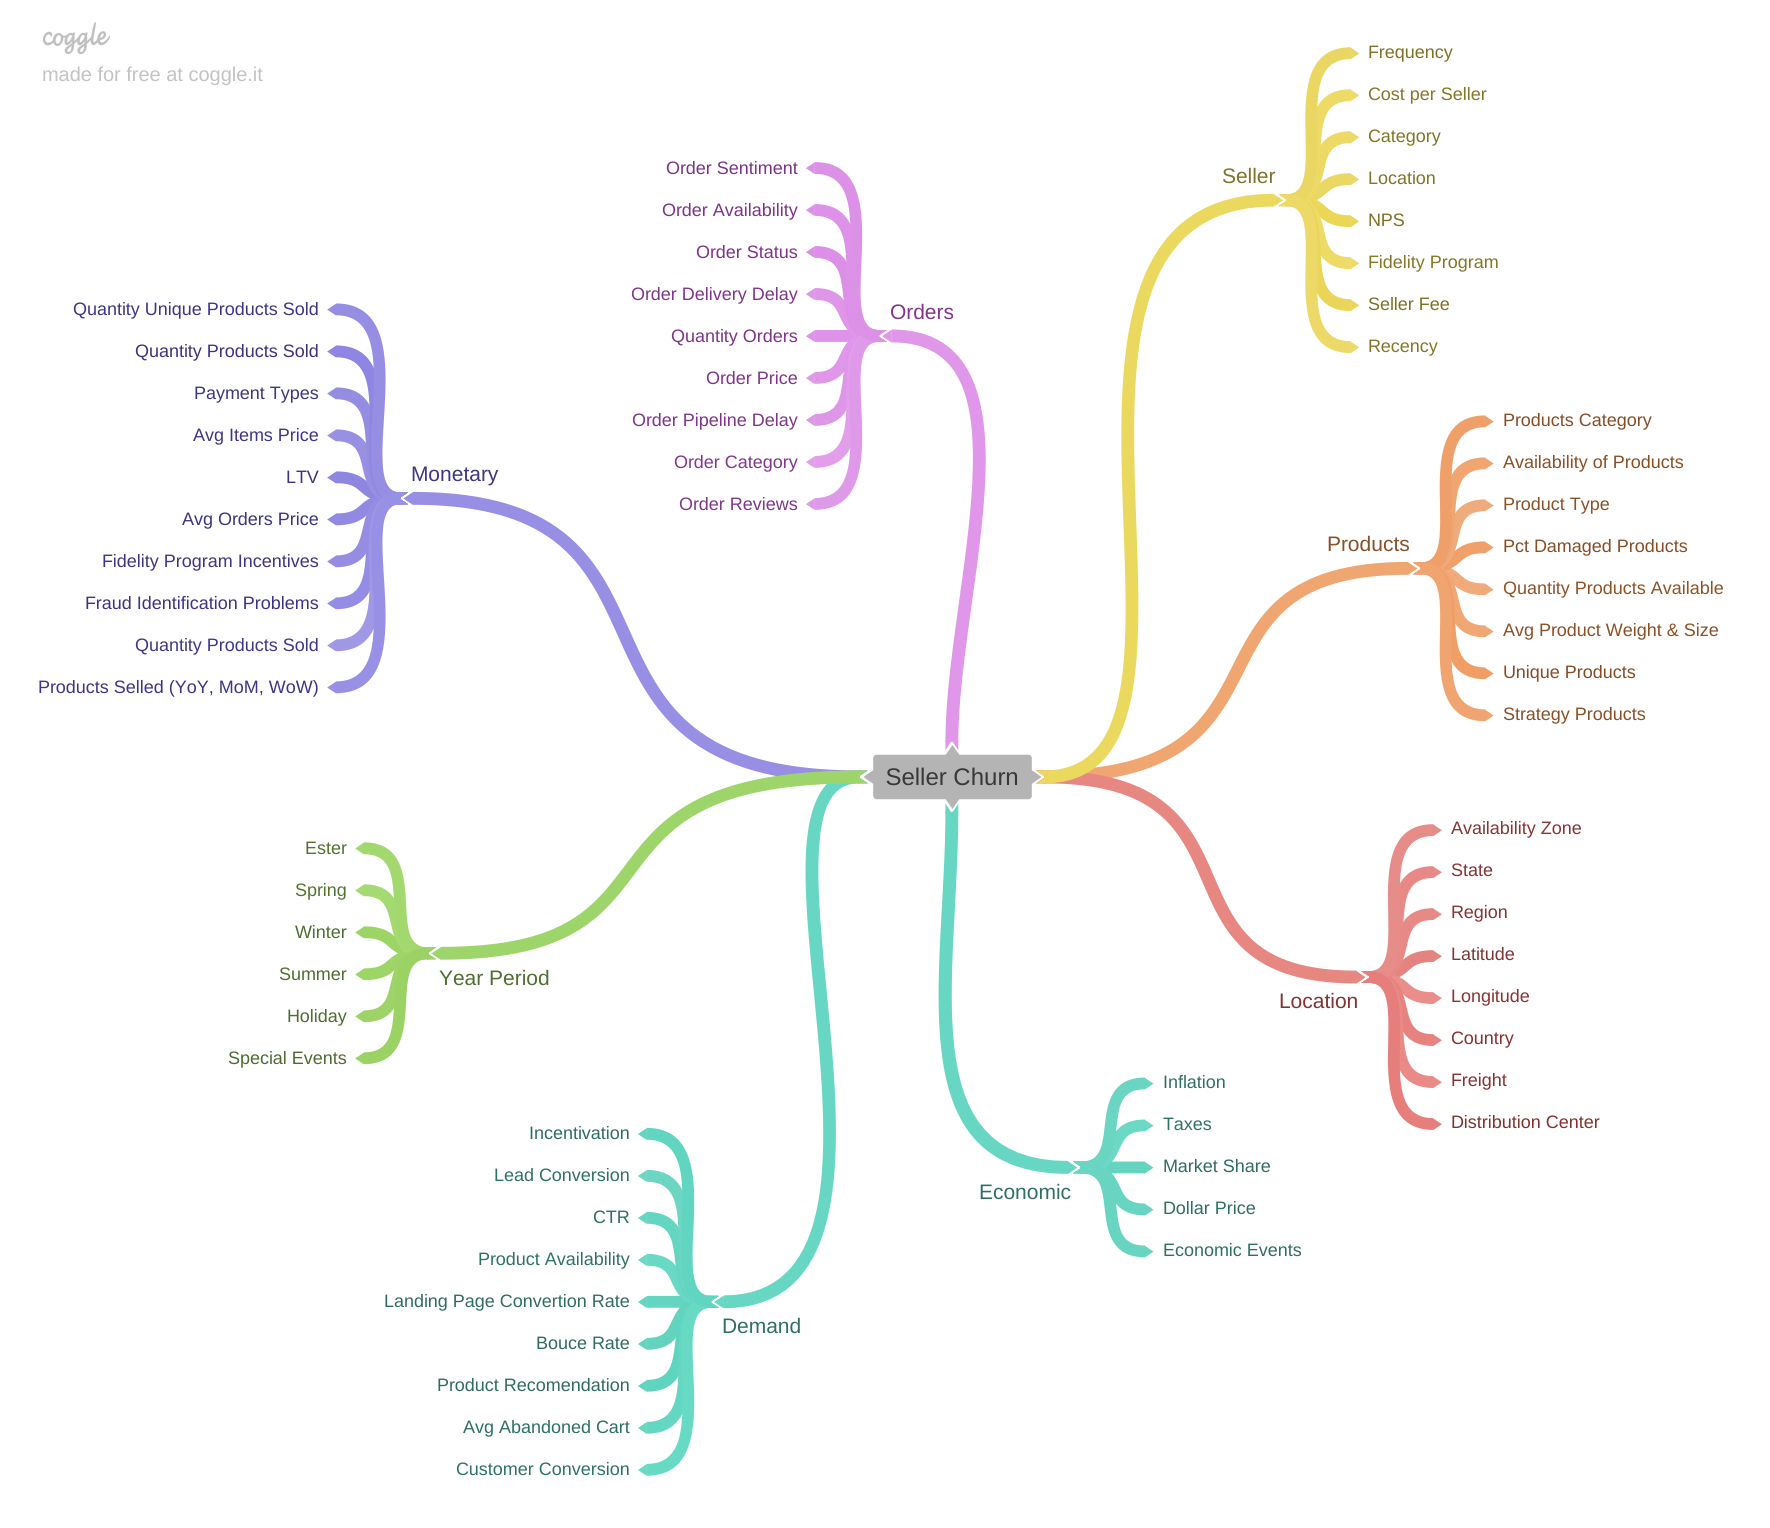

In [54]:
Image("./assets/mindmap.png")

1. Sellers with a selling interval greather than one week, have 20% churn.
2. Sellers with more than one year in Olist marketplace, have 75% to churn.
3. Sellers with more than 75% of delay in orders, have 25% to churn.
4. Sellers with two or three products, have 30% to churn.

## 3.2. Feature Engineering

1. Some Features are created on ABT, other features or external features i need to include in pipeline.

# 4.0. EDA

In [29]:
df4 = df1.copy()

## 4.1. Univariable

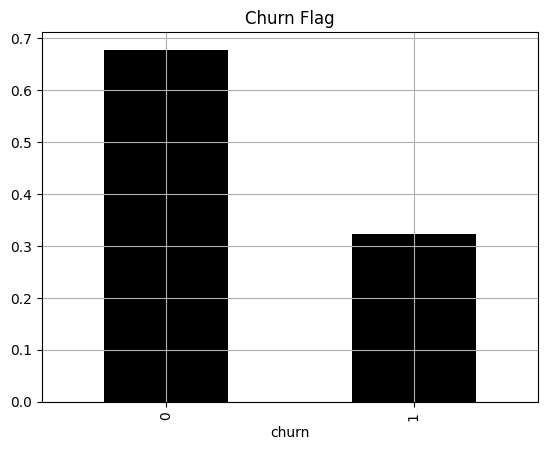

In [32]:
(df4["churn"].value_counts() / len(df4)).plot(kind="bar", grid=2, color="k", title="Churn Flag");

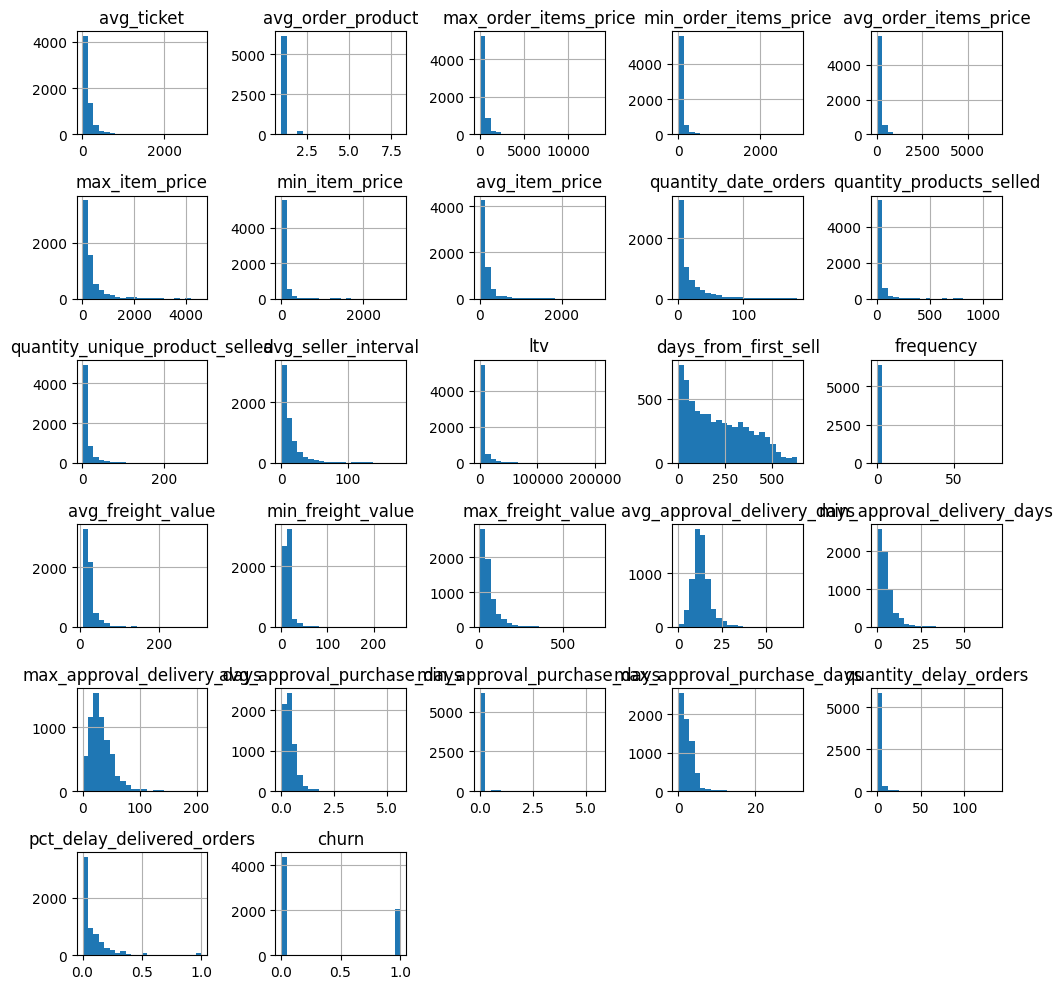

In [33]:
df4.hist(bins=22, figsize=(10, 10))

plt.tight_layout()

## 4.2. Bivariable

#### **1. Sellers with a selling interval greather than one week, have 20% chance to churn.**

True

In [30]:
stats.pointbiserialr(df4["churn"], df4["avg_seller_interval"])

SignificanceResult(statistic=0.23806602397109056, pvalue=9.78244632583377e-84)

In [39]:
df4[["days_from_first_sell", "frequency", "avg_seller_interval"]].corr()

,days_from_first_sell,frequency,avg_seller_interval
days_from_first_sell,1.000000,-0.004387,0.058463
frequency,-0.004387,1.000000,-0.093691
avg_seller_interval,0.058463,-0.093691,1.000000


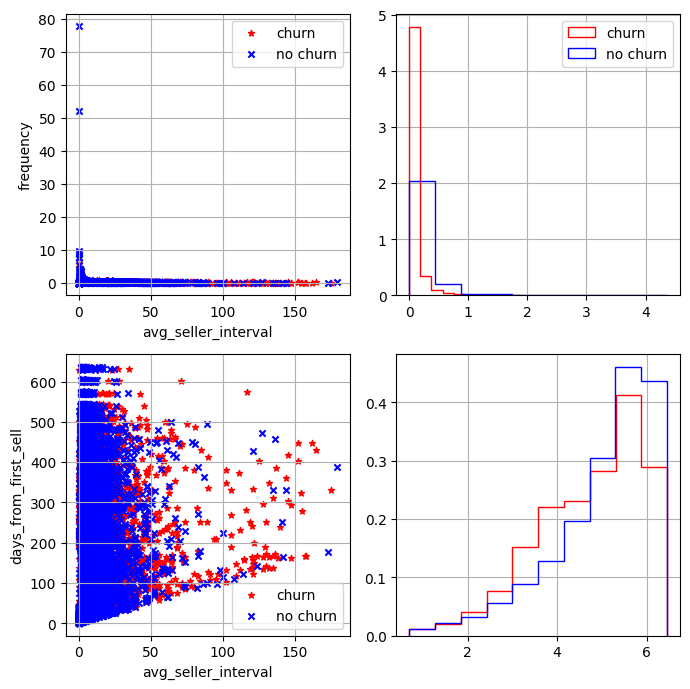

In [89]:
plot_h_scatter_selling_interval(df4, mask)

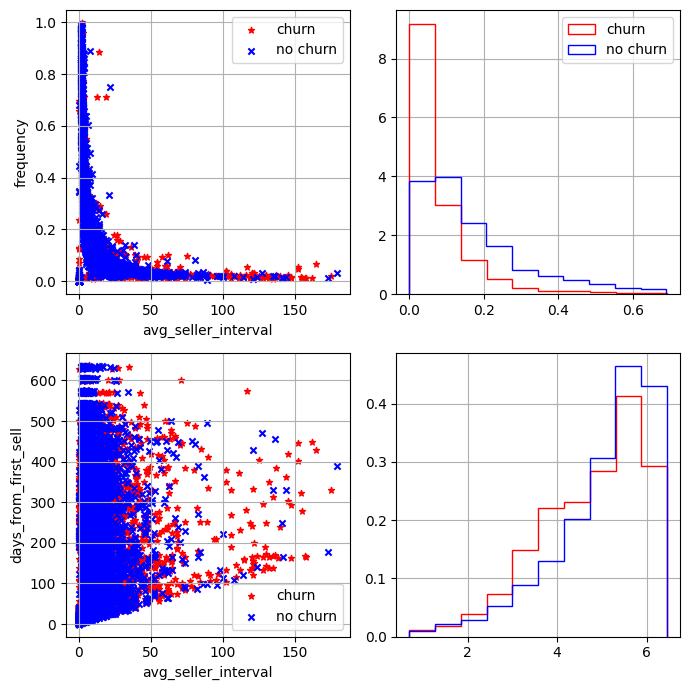

In [146]:
plot_h_scatter_selling_interval(df4[df4["frequency"] <= 1], mask)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6445.000000
mean       13.886680
std        18.864178
min         0.000000
25%         3.531915
50%         8.000000
75%        17.000000
max       179.000000
Name: avg_seller_interval, dtype: float64


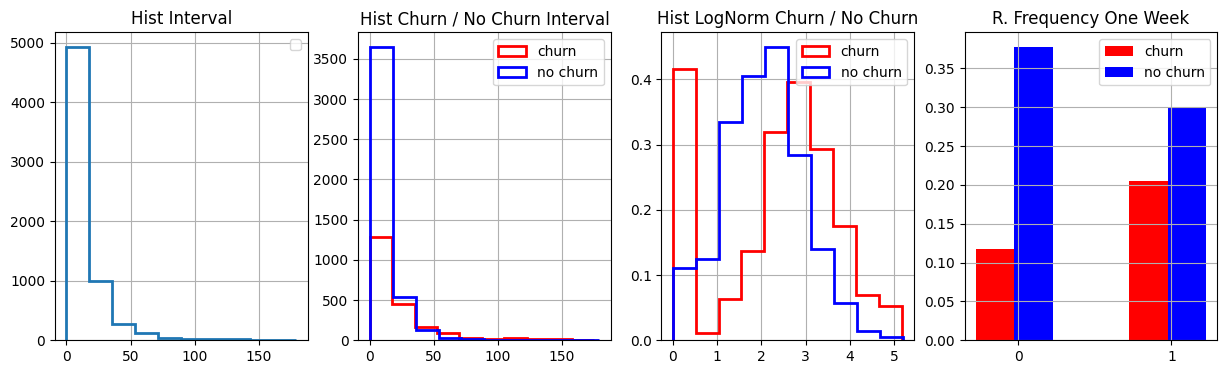

In [35]:
plot_h_selling_interval(df4, mask)

#### **2. Sellers with more than one year in Olist marketplace, have a chance of 75% to churn**

False

In [36]:
stats.pointbiserialr(df4["churn"], df4["days_from_first_sell"])

SignificanceResult(statistic=-0.12468253945827439, pvalue=9.480976533589243e-24)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6445.000000
mean      216.543212
std       161.025513
min         1.000000
25%        71.000000
50%       190.000000
75%       340.000000
max       637.000000
Name: days_from_first_sell, dtype: float64


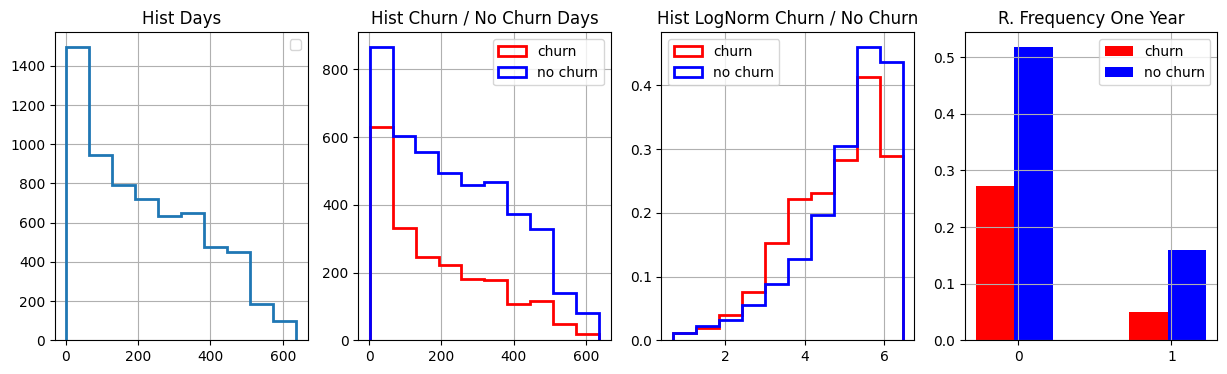

In [37]:
plot_h_one_year_selling(df4, mask)

Looking for complete monthly history of the seller, the seller can churn if not sell in a certain period, but if the seller sell again, the seller will not churn, can be a temporary churn such as events, etc.

In [38]:
df.loc[df["seller_id"] == "ffdd9f82b9a447f6f8d4b91554cc7dd3", ["_mt_date_reference", "recency", "churn", "days_from_first_sell"]]

,_mt_date_reference,recency,churn,days_from_first_sell
1041,2018-01-01,35.0,1,302.0
3165,2018-03-01,8.0,0,361.0
4263,2018-04-01,39.0,0,392.0
5496,2018-05-01,9.0,0,422.0
6763,2018-06-01,40.0,0,453.0
8055,2018-07-01,30.0,1,483.0
9461,2018-08-01,8.0,0,514.0


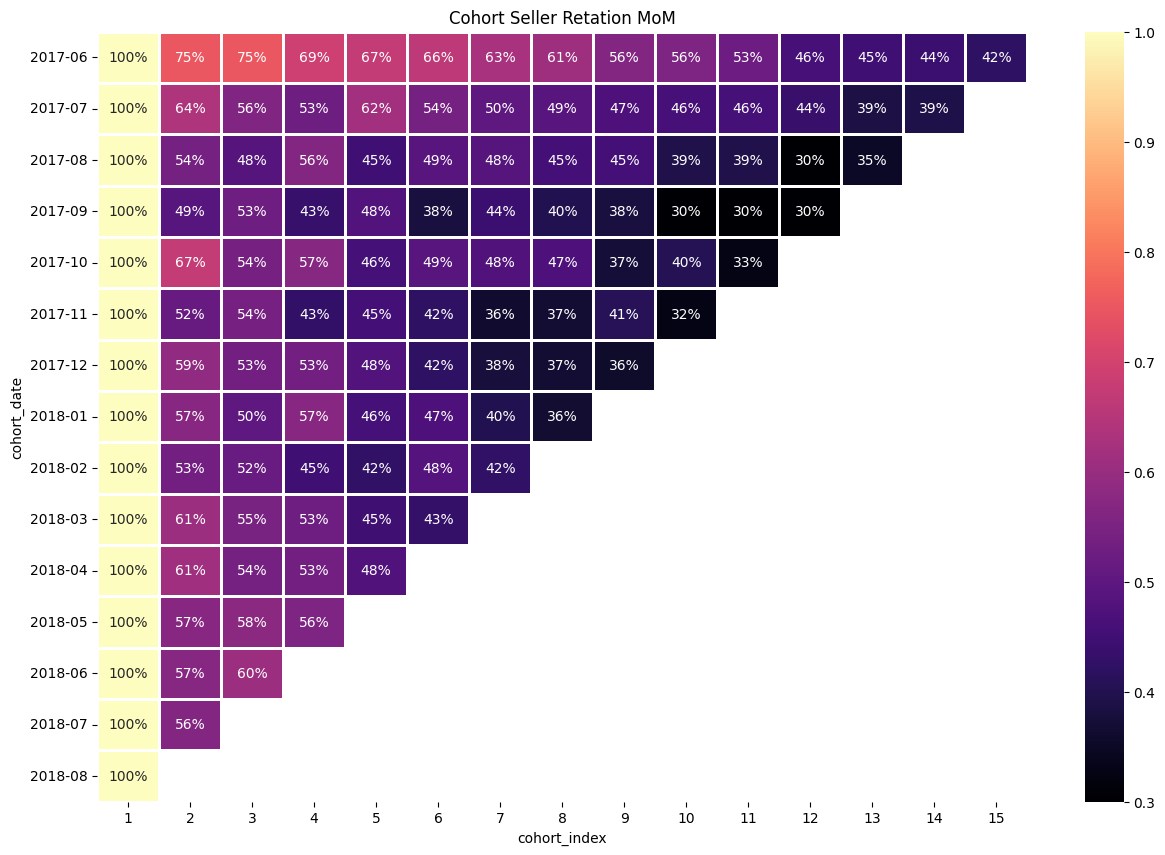

In [132]:
df_cohort = read_query("cohort")
df_cohort = df_cohort.pivot_table(index="cohort_date", columns="cohort_index", values="seller_id")
df_cohort = df_cohort.divide(df_cohort.iloc[:, 0], axis=0).round(3)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_cohort, annot=True, cmap="magma", fmt=".0%", linewidths=2, ax=ax);
ax.set_title("Cohort Seller Retation MoM");

plt.savefig("cohort_retention.png", pad_inches=0)

#### **3. Sellers with more than 75% of delay in orders, have 25% to churn.**

False

In [70]:
stats.pointbiserialr(df4["churn"], df4["pct_delay_delivered_orders"])

SignificanceResult(statistic=0.05624282215030927, pvalue=6.245103089715161e-06)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6445.000000
mean        0.086255
std         0.146922
min         0.000000
25%         0.000000
50%         0.037037
75%         0.115385
max         1.000000
Name: pct_delay_delivered_orders, dtype: float64


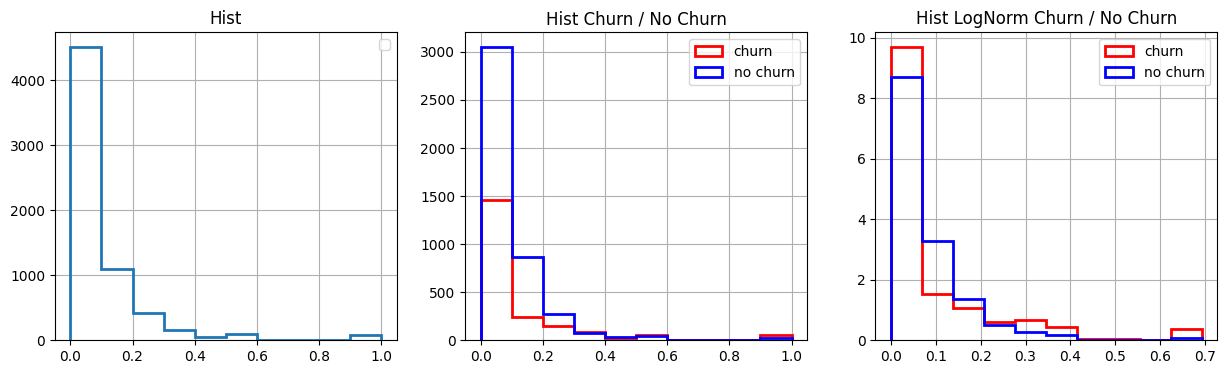

In [71]:
plot_h_histogram(df4, mask)

Long days to be approved, but not show a churn pattern. Have a little poits at > 0.7, maybe overfitting estimator can take this differences.

In [41]:
stats.pointbiserialr(df4["churn"], df4["avg_approval_delivery_days"])

SignificanceResult(statistic=0.05686989516559423, pvalue=4.9153185948166885e-06)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6445.000000
mean       13.356810
std         5.702166
min         0.054618
25%        10.002176
50%        12.677276
75%        15.585576
max        68.153310
Name: avg_approval_delivery_days, dtype: float64


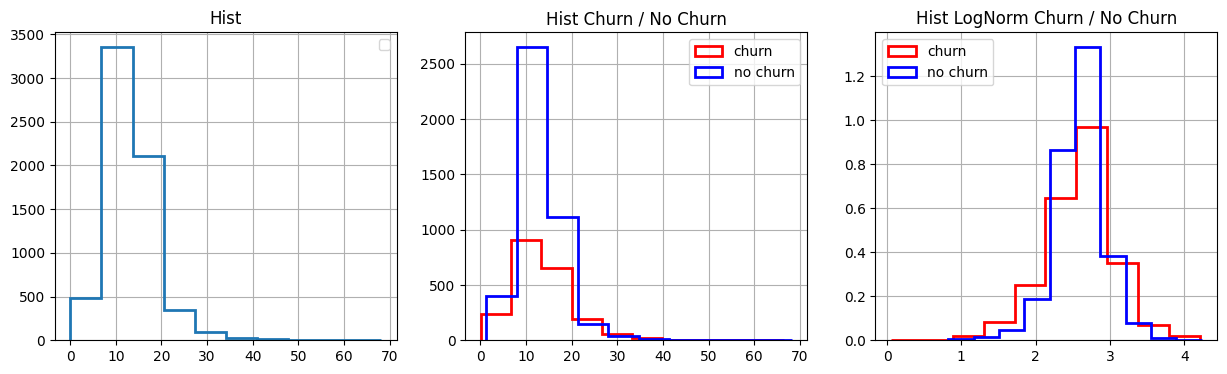

In [42]:
plot_h_histogram(df4, mask, "avg_approval_delivery_days")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6445.000000
mean        5.381860
std         5.170624
min         0.007662
25%         2.115185
50%         3.889514
75%         6.761019
max        68.153310
Name: min_approval_delivery_days, dtype: float64


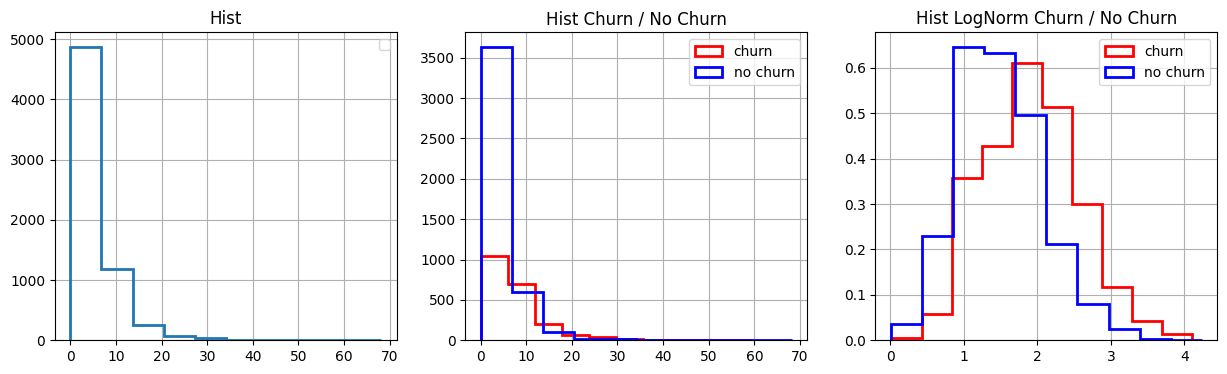

In [43]:
plot_h_histogram(df4, mask, "min_approval_delivery_days")

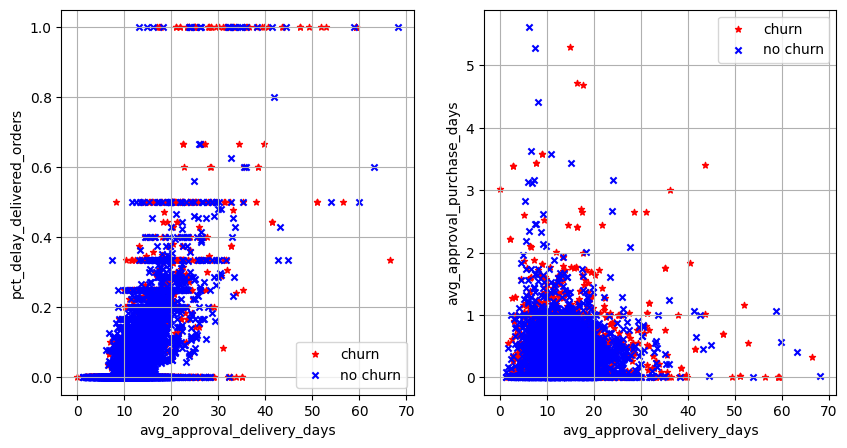

In [44]:
plot_h_scatter_delay(df4, mask)

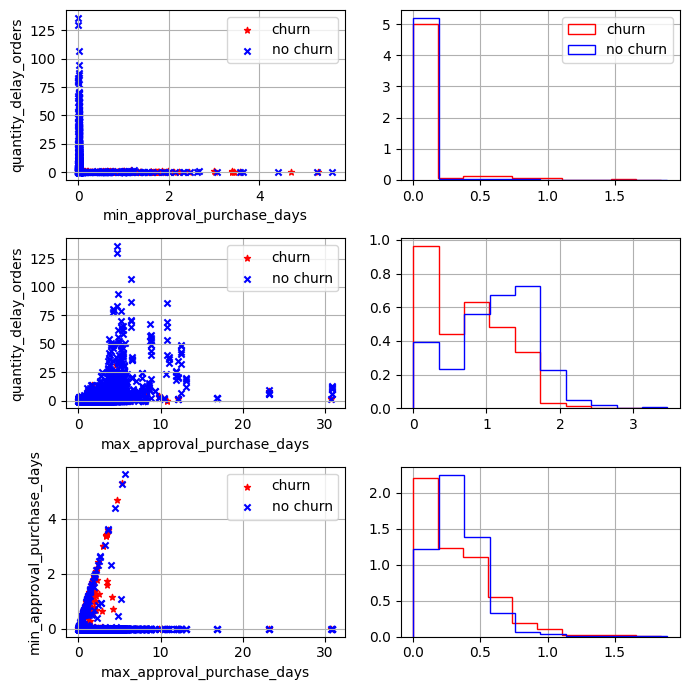

In [86]:
plot_h_scatter_delay_approval(df4, mask)

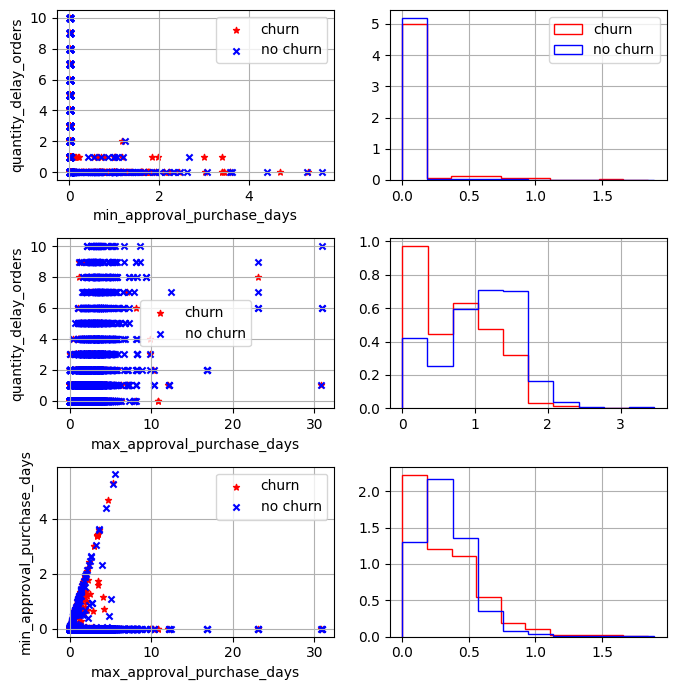

In [147]:
plot_h_scatter_delay_approval(df4[df4.quantity_delay_orders <= 10], mask)

#### **4. Sellers with two or three products, have 30% to churn.**

False

In [139]:
df4.loc[df4["quantity_products_selled"] == df4["quantity_products_selled"].max(),
    ["quantity_date_orders", "quantity_products_selled",
     "quantity_unique_product_selled", "avg_seller_interval", "ltv",
     "churn"]
].T

,3317
quantity_date_orders,173.000000
quantity_products_selled,1125.000000
quantity_unique_product_selled,24.000000
avg_seller_interval,1.052326
ltv,82796.990000
churn,0.000000


Is possible to see a magic number to business.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6445.000000
mean       34.889372
std        83.748921
min         1.000000
25%         4.000000
50%        12.000000
75%        32.000000
max      1125.000000
Name: quantity_products_selled, dtype: float64


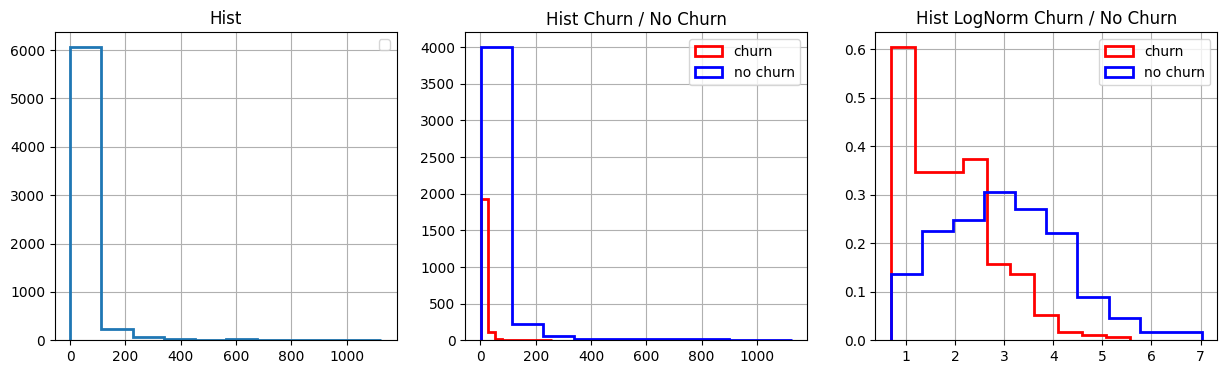

In [134]:
plot_h_histogram(df4, mask, "quantity_products_selled")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    4963.000000
mean       10.530727
std         9.026497
min         1.000000
25%         3.000000
50%         8.000000
75%        16.000000
max        35.000000
Name: quantity_products_selled, dtype: float64


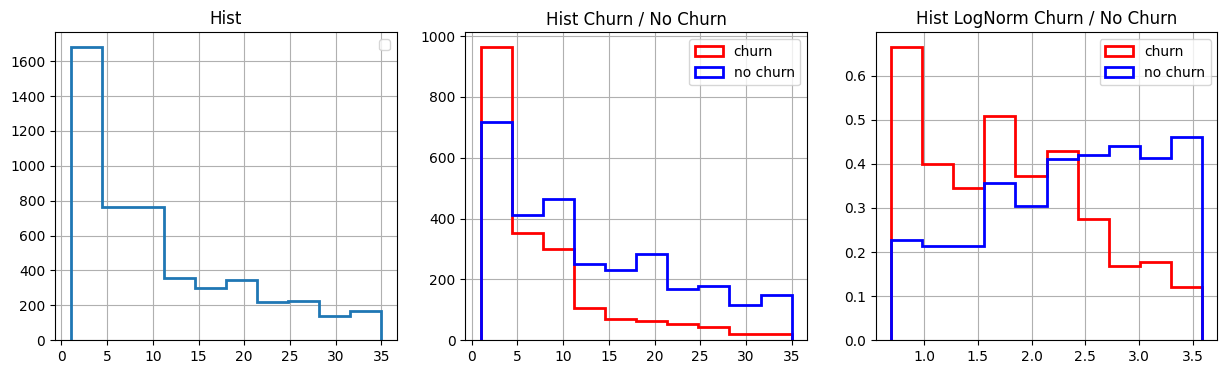

In [148]:
plot_h_histogram(df4[df4.quantity_products_selled <= 35], mask, "quantity_products_selled")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6445.000000
mean       19.411482
std        26.539240
min         1.000000
25%         3.000000
50%         9.000000
75%        24.000000
max       182.000000
Name: quantity_date_orders, dtype: float64


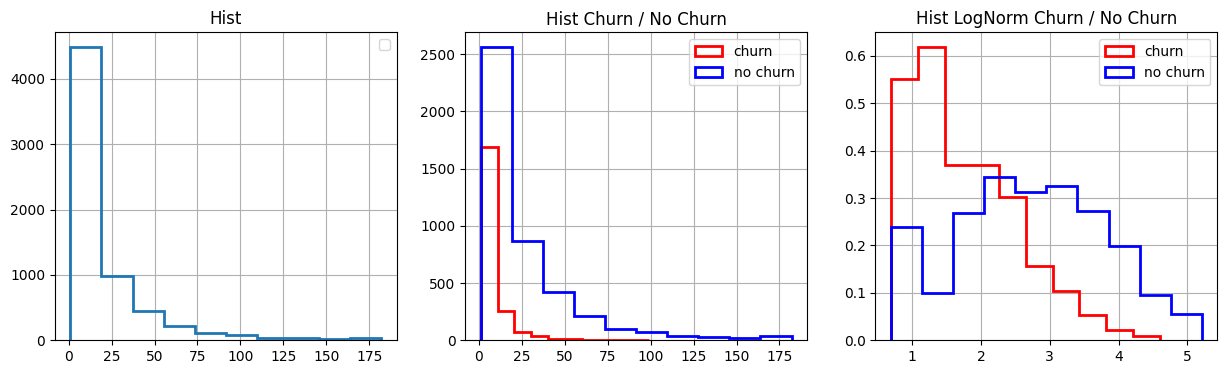

In [140]:
plot_h_histogram(df4, mask, "quantity_date_orders")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6445.000000
mean       12.483320
std        20.982048
min         1.000000
25%         2.000000
50%         6.000000
75%        14.000000
max       290.000000
Name: quantity_unique_product_selled, dtype: float64


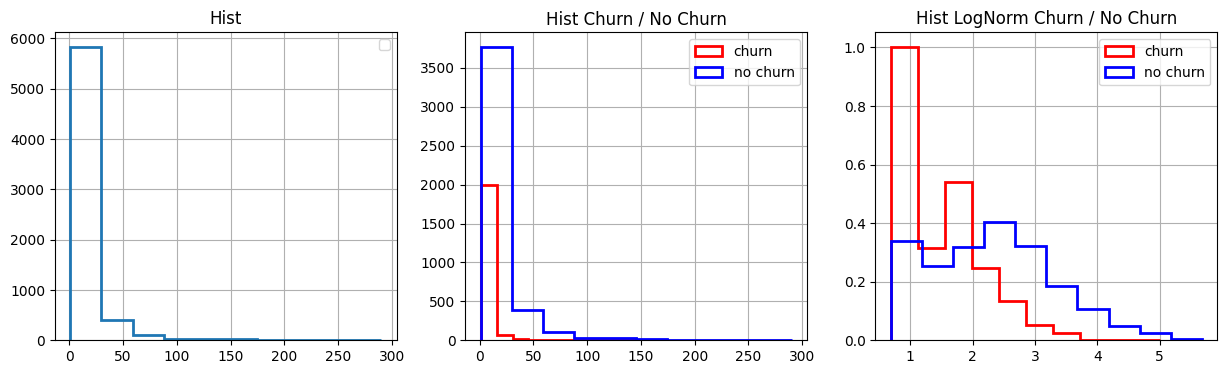

In [141]:
plot_h_histogram(df4, mask, "quantity_unique_product_selled")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


count    6182.000000
mean        9.098835
std         9.676473
min         1.000000
25%         2.000000
50%         6.000000
75%        12.000000
max        50.000000
Name: quantity_unique_product_selled, dtype: float64


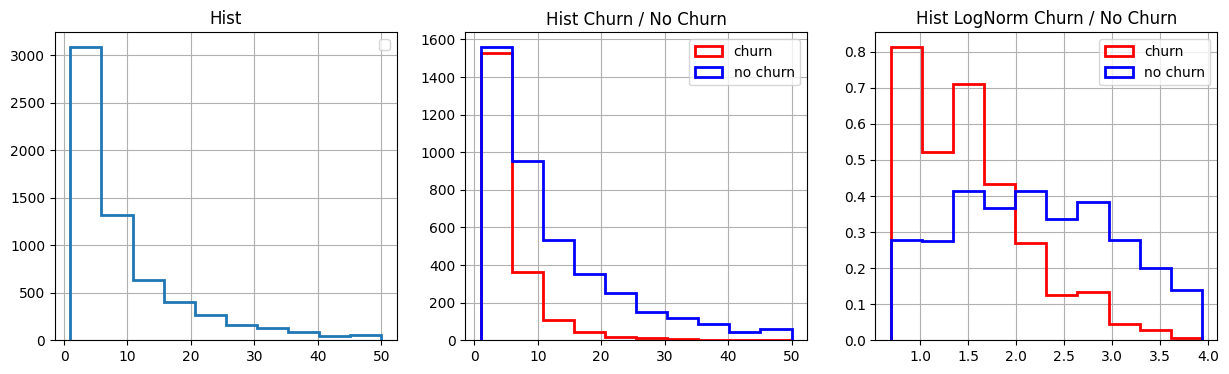

In [151]:
plot_h_histogram(df4[df4.quantity_unique_product_selled <= 50], mask, "quantity_unique_product_selled")

## 4.3. Multivariable

Assumption: A linear correlation between features.

Is possible to check other correlations, at March, 31, 2024 is created a new correlation coefficient, the ksaai coeficient, is possible to check at this post (https://towardsdatascience.com/a-new-coefficient-of-correlation-64ae4f260310).

Is possible to see a high linear correlated features with "min", "max", "avg" and historical features such as LTV and Quantity Date Orders, maybe i will filter some features is only good for descriptive statistics and EDA, not for ML, assuming a linear correlation, feature elimination techniques can filter other too.

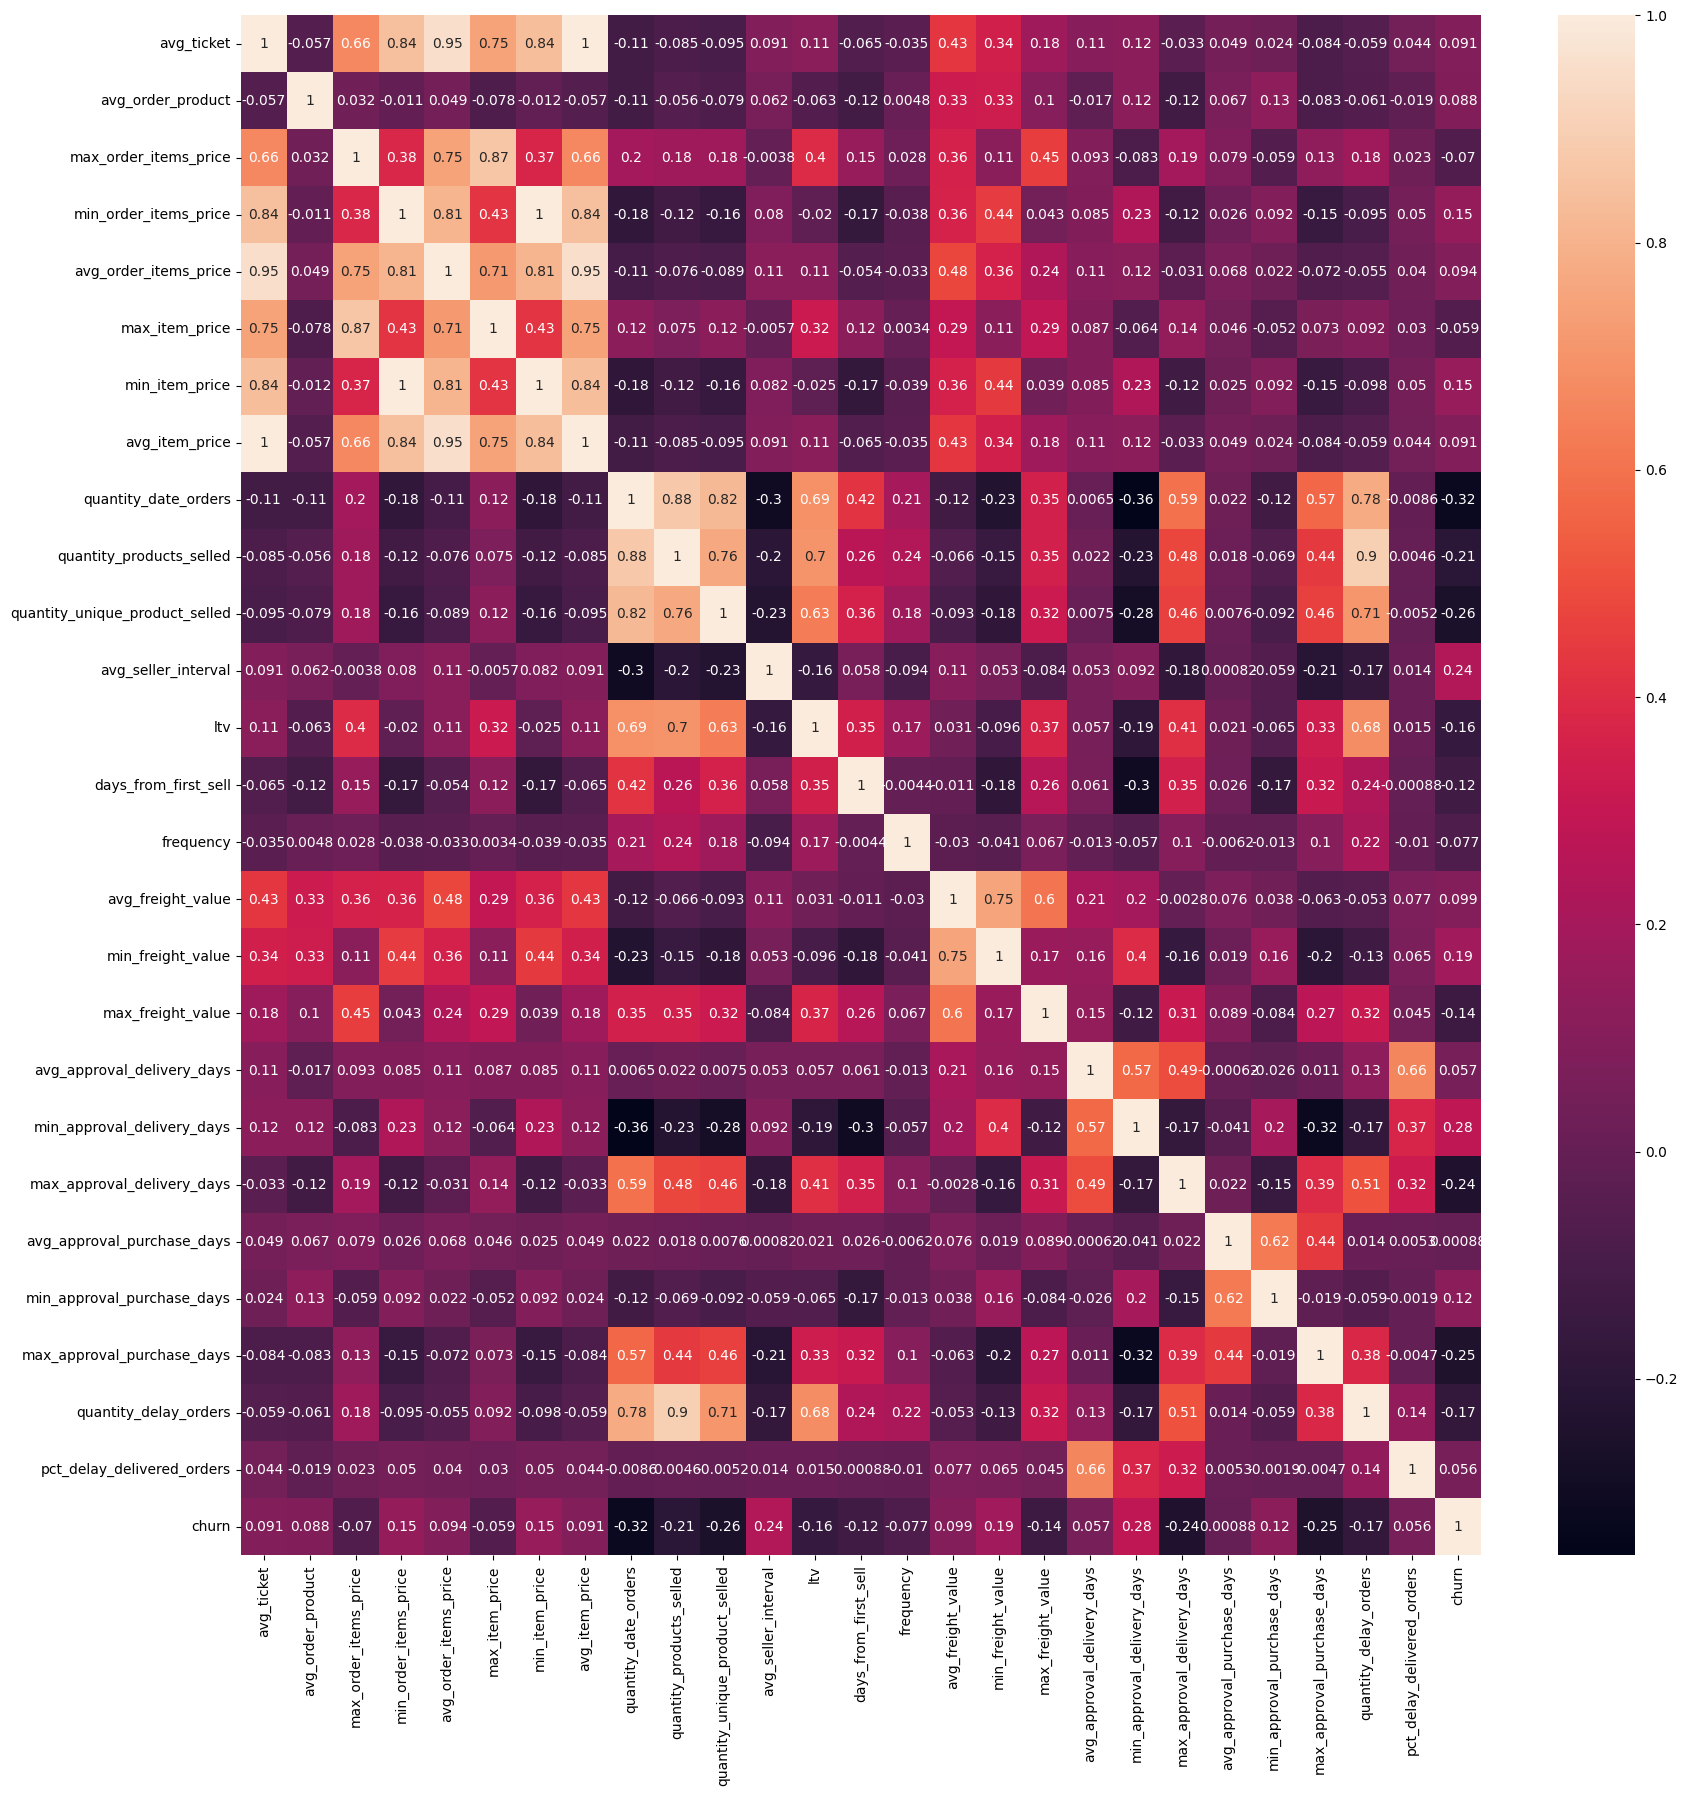

In [45]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df1.corr(method="pearson"), annot=True);

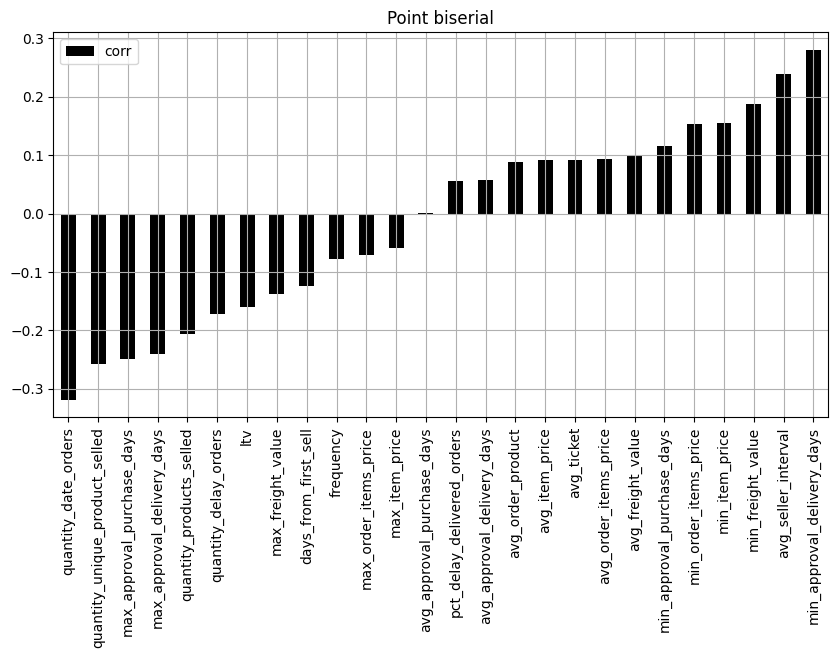

In [47]:
dfc = pd.DataFrame(
    {j: stats.pointbiserialr(df4["churn"], df4[j]).statistic for j in df1.columns[:-1]}, index=[0]
).T.sort_values(0).rename(columns={0:"corr"})

dfc.plot(kind="bar", grid=2, figsize=(10, 5), title="Point biserial", color="k");